## LDSI Project

İrem Gökçek

03737230

### Phase 0: Setup

In [3]:
import spacy
import json
import random
import re
import math
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt

import os
import flask_cors
import regex
import pickle
import nltk
from nltk.corpus import stopwords
import string

In [2]:
#from google.colab import drive 
#drive.mount("/content/gdrive", force_remount=True)

In [4]:
#directory = '/content/gdrive/MyDrive/Colab Notebooks/'
directory = 'C:/Users/iremg/Desktop/dersler/master/ldsi/project/'

corpus_fpath = directory+'ldsi_w21_curated_annotations_v2.json'
data = json.load(open(corpus_fpath))

### Phase 1: Dataset Splitting

%10 test set of 7 granted and 7 denied decisions

%10 dev set

%80 train set


In [5]:
# to know the data style of ldsi_w21_curated_annotations_v2.json
data_style = {
    "documents": [
    {
      "_id": "61aea55c97ad59b4cfc4128c",
      "name": "0601461.txt",
      "plainText": "Citation Nr: 0601461...",
      "outcome": "remanded"
    },
    ...
  ],
  "annotations": [
    {
      "_id": "61bb066d97ad59b4cfc4699a",
      "start": 15922,
      "end": 16078,
      "document": "61aea57397ad59b4cfc41399",
      "type": "61aeaf8097ad59b4cfc416d7"
    }, 
    ...
    ],
  "types": [
    {
      "_id": "61aeaf8097ad59b4cfc416d7",
      "name": "CaseFooter",
      "isA": "58781cf945f90f3bfc5cba7d",
      "attributes": []
    },
    ...
  ]
}

The following code snippet is from the LDSI WS2021-2022 Text Classification Workshop

In [6]:
annotations = data['annotations']
documents_by_id = {d['_id']: d for d in data['documents']}
types_by_id = {t['_id']: t for t in data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in data['types']}
type_names_by_id = {t['_id']: t['name'] for t in data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in data['documents']}

In [19]:
documents_by_id['61aea57497ad59b4cfc413e9']['name']

'1615107.txt'

In [6]:
len(set(documents_by_id))

540

In [7]:
granted_documents_by_ids = [d['_id'] for d in data['documents'] if d['outcome']=='granted']
denied_documents_by_ids = [d['_id'] for d in data['documents'] if d['outcome']=='denied']
remanded_documents_by_ids = [d['_id'] for d in data['documents'] if d['outcome']=='remanded']
print("Granted document count: ", len(granted_documents_by_ids), 
      "\nDenied document count: ", len(denied_documents_by_ids),
      "\nRemanded document count: ", len(remanded_documents_by_ids))

Granted document count:  180 
Denied document count:  180 
Remanded document count:  180


In [8]:
set(granted_documents_by_ids) & set(denied_documents_by_ids) 

set()

In [9]:
annotated_documents = [d['document'] for d in annotations]
len(annotated_documents)

15349

In [10]:
annotated_documents_ids = set(annotated_documents)

In [11]:
print("Total document count: ", len(annotated_documents_ids))

Total document count:  141


In [12]:
granted_documents_by_ids = [d['_id'] for d in data['documents'] if d['outcome']=='granted' and d['_id'] in annotated_documents_ids]
denied_documents_by_ids = [d['_id'] for d in data['documents'] if d['outcome']=='denied' and d['_id'] in annotated_documents_ids]
remanded_documents_by_ids = [d['_id'] for d in data['documents'] if d['outcome']=='remanded' and d['_id'] in annotated_documents_ids]
print("Granted document count: ", len(granted_documents_by_ids), 
      "\nDenied document count: ", len(denied_documents_by_ids),
      "\nRemanded document count: ", len(remanded_documents_by_ids))


Granted document count:  70 
Denied document count:  71 
Remanded document count:  0


In [13]:
len(set(granted_documents_by_ids))

70

In [14]:
granted_documents_by_ids[0]

'61aea55c97ad59b4cfc41290'

In [15]:
test_set=[]
dev_set=[]
train_set=[]

random.shuffle(granted_documents_by_ids)
random.shuffle(denied_documents_by_ids)

test_set.extend(granted_documents_by_ids[0:7])
test_set.extend(denied_documents_by_ids[0:7])

dev_set.extend(granted_documents_by_ids[7:14])
dev_set.extend(denied_documents_by_ids[7:14])

train_set.extend(granted_documents_by_ids[14:])
train_set.extend(denied_documents_by_ids[14:])

print("Test set count: ", len(test_set), "\t-> %", len(test_set)/len(annotated_documents_ids)*100, 
      "\nDev set count: ", len(dev_set), "\t-> %", len(dev_set)/len(annotated_documents_ids)*100, 
      "\nTrain set count: ", len(train_set), "\t-> %", len(train_set)/len(annotated_documents_ids)*100)

Test set count:  14 	-> % 9.929078014184398 
Dev set count:  14 	-> % 9.929078014184398 
Train set count:  113 	-> % 80.1418439716312


Making sure that there isnt any data leakage

In [16]:
set(test_set) & set(dev_set) 

set()

In [17]:
set(dev_set) & set(train_set) 

set()

In [18]:
set(test_set) & set(train_set) 

set()

In [19]:
test_documents_by_id = {i: documents_by_id[i] for i in test_set }
dev_documents_by_id = {i: documents_by_id[i] for i in dev_set }
train_documents_by_id = {i: documents_by_id[i] for i in train_set }

print("Test Documents count: ", len(test_documents_by_id),
      "\nDev Documents count: ", len(dev_documents_by_id),
      "\nTrain Documents count: ", len(train_documents_by_id))

Test Documents count:  14 
Dev Documents count:  14 
Train Documents count:  113


In [20]:
test_id = [i for i in test_documents_by_id]
test_id

['61aea55f97ad59b4cfc41334',
 '61aea55d97ad59b4cfc412b7',
 '61aea55f97ad59b4cfc41307',
 '61aea55c97ad59b4cfc4129e',
 '61aea55d97ad59b4cfc412c1',
 '61aea55e97ad59b4cfc412fd',
 '61aea55d97ad59b4cfc412d3',
 '61aea57197ad59b4cfc41376',
 '61aea57497ad59b4cfc413be',
 '61aea57497ad59b4cfc413c4',
 '61aea57497ad59b4cfc413d2',
 '61aea57097ad59b4cfc41368',
 '61aea57397ad59b4cfc4139e',
 '61aea57397ad59b4cfc4139c']

In [21]:
dev_id = [i for i in dev_documents_by_id]
dev_id

['61aea55e97ad59b4cfc412e6',
 '61aea55c97ad59b4cfc412a3',
 '61aea55f97ad59b4cfc41328',
 '61aea55c97ad59b4cfc412ae',
 '61aea55e97ad59b4cfc412d4',
 '61aea55f97ad59b4cfc41336',
 '61aea55f97ad59b4cfc41318',
 '61aea57497ad59b4cfc413e9',
 '61aea57497ad59b4cfc413da',
 '61aea57497ad59b4cfc413e1',
 '61aea57397ad59b4cfc41393',
 '61aea57497ad59b4cfc413bd',
 '61aea57497ad59b4cfc413b6',
 '61aea57097ad59b4cfc4135a']

The following snipppet is adjusted from: https://web.archive.org/web/20170228011551/http://matplotlib.org/examples/api/barchart_demo.html

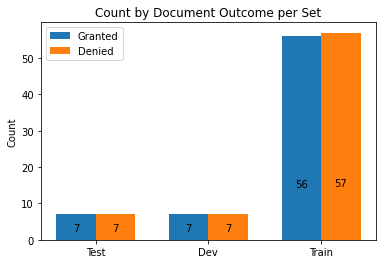

In [22]:
test_granted = len({i: documents_by_id[i] for i in test_documents_by_id if  documents_by_id[i]['outcome']=='granted'})
test_denied = len({i: documents_by_id[i] for i in test_documents_by_id if  documents_by_id[i]['outcome']=='denied'})
dev_granted = len({i: documents_by_id[i] for i in dev_documents_by_id if  documents_by_id[i]['outcome']=='granted'})
dev_denied = len({i: documents_by_id[i] for i in dev_documents_by_id if  documents_by_id[i]['outcome']=='denied'})
train_granted = len({i: documents_by_id[i] for i in train_documents_by_id if  documents_by_id[i]['outcome']=='granted'})
train_denied = len({i: documents_by_id[i] for i in train_documents_by_id if  documents_by_id[i]['outcome']=='denied'})

labels = ['Test', 'Dev', 'Train']
granted_count = [test_granted, dev_granted, train_granted]
denied_count = [test_denied, dev_denied, train_denied]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, granted_count, width, label='Granted')
rects2 = ax.bar(x + width/2, denied_count, width, label='Denied')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Set')
ax.set_title('Count by Document Outcome per Set')
ax.legend()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .25*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

tickvalues = range(0,len(x)) 
plt.xticks(ticks = tickvalues ,labels = labels, rotation = 'horizontal')

plt.show()

The following 3 code snippets are from the LDSI WS2021-2022 Text Classification Workshop

In [23]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations):
    span_data = []
    for a in annotations:
        start = a['start']
        end = a['end']
        document_txt = documents_by_id[a['document']]['plainText']
        atype = a['type']
        sd = {'txt': document_txt[start:end],
              'document': a['document'],
              'type': types_by_id[atype]['name'],
              'start': a['start'],
              'start_normalized': a['start'] / len(document_txt),
              'end': a['end'],
              'outcome': documents_by_id[a['document']]['outcome']
              }
        span_data.append(sd)
    return span_data

In [24]:
spans = make_span_data(documents_by_id, types_by_id, annotations)
span_labels = [s['type'] for s in spans]

In [25]:
spans[0]

{'txt': "____________________________________________\r\nDEBORAH W. SINGLETON\r\nVeterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\n\r\n Department of Veterans Affairs\r",
 'document': '61aea57397ad59b4cfc41399',
 'type': 'CaseFooter',
 'start': 15922,
 'start_normalized': 0.9899894298327426,
 'end': 16078,
 'outcome': 'denied'}

Now, split the spans based on document id for test, dev, train sets

In [26]:
test_spans = [s for s in spans if s['document'] in list(test_documents_by_id.keys())]
dev_spans = [s for s in spans if s['document'] in list(dev_documents_by_id.keys())]
train_spans = [s for s in spans if s['document'] in list(train_documents_by_id.keys())]

test_span_labels = [s['type'] for s in test_spans]
dev_span_labels = [s['type'] for s in dev_spans]
train_span_labels = [s['type'] for s in train_spans]

test_spans_txt = [s['txt'] for s in test_spans]
dev_spans_txt = [s['txt'] for s in dev_spans]
train_spans_txt = [s['txt'] for s in train_spans]

In [27]:
print("Test Spans count: ", len(test_spans),
      "\nDev Spans count: ", len(dev_spans),
      "\nTrain Spans count: ", len(train_spans))

Test Spans count:  1334 
Dev Spans count:  1637 
Train Spans count:  12378


In [28]:
train_spans[0]

{'txt': "____________________________________________\r\nDEBORAH W. SINGLETON\r\nVeterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\n\r\n Department of Veterans Affairs\r",
 'document': '61aea57397ad59b4cfc41399',
 'type': 'CaseFooter',
 'start': 15922,
 'start_normalized': 0.9899894298327426,
 'end': 16078,
 'outcome': 'denied'}

In [29]:
print("Test Spans Labels count: ", len(test_span_labels),
      "\nDev Spans Labels count: ", len(dev_span_labels),
      "\nTrain Spans Labels count: ", len(train_span_labels))

Test Spans Labels count:  1334 
Dev Spans Labels count:  1637 
Train Spans Labels count:  12378


In [30]:
test_span_labels[0]

'CaseHeader'

In [31]:
print("Test Spans Text count: ", len(test_spans_txt),
      "\nDev Spans Text count: ", len(dev_spans_txt),
      "\nTrain Spans Text count: ", len(train_spans_txt))

Test Spans Text count:  1334 
Dev Spans Text count:  1637 
Train Spans Text count:  12378


In [32]:
train_spans_txt[0]

"____________________________________________\r\nDEBORAH W. SINGLETON\r\nVeterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\n\r\n Department of Veterans Affairs\r"

### Phase 2: Deciding on a Sentence Segmenter

2.1 Standard segmentation analysis

Sentence segmentation with Spacy, https://www.geeksforgeeks.org/python-perform-sentence-segmentation-using-spacy/

In [34]:
nlp = spacy.load("en_core_web_sm")

In [35]:
pred_annotations=[]

for id in train_documents_by_id:
    plainText = train_documents_by_id[id]['plainText']
    doc = nlp(plainText)
    for sent in doc.sents:
        annotation={
        'document':id,
        'end':sent.end_char,
        'start':sent.start_char,
        'txt':str(sent)
        }
        pred_annotations.append(annotation)

In [36]:
pred_annotations[0]

{'document': '61aea55c97ad59b4cfc4129d',
 'end': 86,
 'start': 0,
 'txt': 'Citation Nr: 0640279\t\r\nDecision Date: 12/29/06    Archive Date: 01/05/07\r\n\r\nDOCKET NO.'}

In [37]:
pred_annotations[0]['end']

86

In [38]:
type(pred_annotations)

list

In [39]:
#with open(directory+'pred_annotations.pickle', 'wb') as handle:
#    pickle.dump(pred_annotations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
with open(directory+'pred_annotations.pickle', 'rb') as handle:
    pred_annotations = pickle.load(handle)

Error Analysis

In [41]:
true_annotations = train_spans.copy()

In [42]:
len(train_spans)

12361

In [43]:
true_annotations[0]

{'txt': "____________________________________________\r\nDEBORAH W. SINGLETON\r\nVeterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\n\r\n Department of Veterans Affairs\r",
 'document': '61aea57397ad59b4cfc41399',
 'type': 'CaseFooter',
 'start': 15922,
 'start_normalized': 0.9899894298327426,
 'end': 16078,
 'outcome': 'denied'}

In [44]:
true_annotations[0]['document']

'61aea57397ad59b4cfc41399'

In [45]:
type(true_annotations)

list

In [46]:
true_positive = 0
true_positive_annotations = []

for k in range(10):
    for i in true_annotations:
        for j in pred_annotations:
            if i['document']==j['document'] and abs(i['start']-j['start'])<=3: #and abs(i['end']-j['end'])<=3:
                true_positive+=1
                true_positive_annotations.append(i)
                true_annotations.remove(i)
                pred_annotations.remove(j)
    print(true_positive)

4563
6660
7493
7654
7668
7668
7668
7668
7668
7668


In [47]:
false_negative = len(true_annotations)
false_positive = len(pred_annotations)
precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive+false_negative)
F1=2*(precision*recall)/(precision+recall)
print("Accross all training data\nTrue Positive: ", true_positive,
      "\nFalse Negative: ", false_negative,
      "\nFalse Positive: ", false_positive,
      "\nPrecision: ", precision,
      "\nRecall: ", recall,
      "\nF1 score: ", F1)

Accross all training data
True Positive:  7668 
False Negative:  4693 
False Positive:  5124 
Precision:  0.599437148217636 
Recall:  0.6203381603430144 
F1 score:  0.6097085834691688


In [48]:
true_positive_annotations[0]

{'txt': '\r\nPertinent Laws and Regulations\r',
 'document': '61aea57397ad59b4cfc41399',
 'type': 'Header',
 'start': 7648,
 'start_normalized': 0.47553317167195175,
 'end': 7681,
 'outcome': 'denied'}

In [49]:
true_positive_annotations[0]['document']

'61aea57397ad59b4cfc41399'

In [50]:
true_annotations[0]

{'txt': "____________________________________________\r\nDEBORAH W. SINGLETON\r\nVeterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\n\r\n Department of Veterans Affairs\r",
 'document': '61aea57397ad59b4cfc41399',
 'type': 'CaseFooter',
 'start': 15922,
 'start_normalized': 0.9899894298327426,
 'end': 16078,
 'outcome': 'denied'}

In [51]:
pred_annotations[0]

{'document': '61aea55c97ad59b4cfc4129d',
 'end': 283,
 'start': 87,
 'txt': ' 02-15 119\t)\tDATE\r\n\t)\r\n\t)\r\n\r\nOn appeal from the\r\nDepartment of Veterans Affairs Regional Office in Huntington, \r\nWest Virginia\r\n\r\n\r\nTHE ISSUE\r\n\r\nEntitlement to service connection for brain damage.'}

In [52]:
# document level error metrics
doc_ids = list(set([s['document'] for s in train_spans]))

error_per_doc = {}

for i in doc_ids:
    TP = len([true_positive_annotations[j] for j in range(len(true_positive_annotations)) if true_positive_annotations[j]['document']==i])
    FN = len([true_annotations[j] for j in range(len(true_annotations)) if true_annotations[j]['document']==i])
    FP = len([pred_annotations[j] for j in range(len(pred_annotations)) if pred_annotations[j]['document']==i])
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    doc_error = {
      'TP': TP,
      'FN': FN,
      'FP': FP,
      'precision': precision,
      'recall': recall,
      'F1': 2*(precision*recall)/(precision+recall)
    }
    error_per_doc[i] = doc_error

len(error_per_doc)

113

In [53]:
f1s = sorted((error_per_doc[doc]['F1'] for doc in error_per_doc),reverse = False)

print("Lowest F1 score 1: ", f1s[0],
      "\nLowest F1 score 2: ", f1s[1],
      "\nLowest F1 score 3: ", f1s[2],
      "\nHighest F1 score: ", f1s[112])

Lowest F1 score 1:  0.35555555555555557 
Lowest F1 score 2:  0.3714285714285715 
Lowest F1 score 3:  0.4 
Highest F1 score:  0.7162534435261709


In [54]:
doc_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[0]]
doc_id

['61aea55e97ad59b4cfc412f0']

In [55]:
lowest1_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[0]][0]
lowest2_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[1]][0]
lowest3_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[2]][0]
highest_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[112]][0]
print(lowest1_id,lowest2_id,lowest3_id,highest_id)

61aea55e97ad59b4cfc412f0 61aea55c97ad59b4cfc412ae 61aea55e97ad59b4cfc412de 61aea57497ad59b4cfc413d1


In [57]:
error_per_doc['61aea55e97ad59b4cfc412f0']

{'TP': 8,
 'FN': 17,
 'FP': 12,
 'precision': 0.4,
 'recall': 0.32,
 'F1': 0.35555555555555557}

In [58]:
#false_negative = len(true_annotations) doğru olması gereken ama beceremediklerim
#false_positive = len(pred_annotations) yanlış yaptıklarım
#true_positive_annotations doğru yaptıklarım

doc1 = [i for i in pred_annotations if i['document']=='61aea55e97ad59b4cfc412f0']
doc1

[{'document': '61aea55e97ad59b4cfc412f0',
  'end': 336,
  'start': 87,
  'txt': ' 09-49 777\t)\tDATE\r\n\t)\r\n\t)\r\n\r\nOn appeal from the\r\nDepartment of Veterans Affairs Regional Office in Portland, Oregon\r\n\r\n\r\nTHE ISSUE\r\n\r\nEntitlement to service connection for hypertension, to include as secondary to service-connected disease or injury.'},
 {'document': '61aea55e97ad59b4cfc412f0',
  'end': 513,
  'start': 336,
  'txt': "\r\n\r\n\r\nREPRESENTATION\r\n\r\nVeteran represented by:\tOregon Department of Veterans' Affairs\r\n\r\n\r\nATTORNEY FOR THE BOARD\r\n\r\nY. Venters, Associate Counsel\r\n\r\n\r\n\r\n\r\n\r\n\r\nINTRODUCTION\r\n\r\n"},
 {'document': '61aea55e97ad59b4cfc412f0',
  'end': 688,
  'start': 575,
  'txt': "\r\n\r\nThis matter initially came before the Board of Veterans' Appeals (Board) from a January 2009 rating decision."},
 {'document': '61aea55e97ad59b4cfc412f0',
  'end': 793,
  'start': 688,
  'txt': '\r\n\r\nThe case was remanded for further development i

In [59]:
doc1 = [i for i in true_annotations if i['document']=='61aea55e97ad59b4cfc412f0']
doc1

[{'txt': 'On appeal from the\r\nDepartment of Veterans Affairs Regional Office in Portland, Oregon',
  'document': '61aea55e97ad59b4cfc412f0',
  'type': 'Procedure',
  'start': 116,
  'start_normalized': 0.06426592797783934,
  'end': 202,
  'outcome': 'granted'},
 {'txt': 'THE ISSUE',
  'document': '61aea55e97ad59b4cfc412f0',
  'type': 'Header',
  'start': 208,
  'start_normalized': 0.11523545706371191,
  'end': 217,
  'outcome': 'granted'},
 {'txt': 'Entitlement to service connection for hypertension, to include as secondary to service-connected disease or injury.',
  'document': '61aea55e97ad59b4cfc412f0',
  'type': 'CaseIssue',
  'start': 221,
  'start_normalized': 0.12243767313019391,
  'end': 336,
  'outcome': 'granted'},
 {'txt': 'REPRESENTATION',
  'document': '61aea55e97ad59b4cfc412f0',
  'type': 'Header',
  'start': 342,
  'start_normalized': 0.18947368421052632,
  'end': 356,
  'outcome': 'granted'},
 {'txt': 'ATTORNEY FOR THE BOARD',
  'document': '61aea55e97ad59b4cfc412f0',

In [ ]:
doc1_types = [t['type'] for t in doc1]
set(doc1_types)

In [61]:
error_per_doc['61aea55c97ad59b4cfc412ae']

{'TP': 13,
 'FN': 25,
 'FP': 19,
 'precision': 0.40625,
 'recall': 0.34210526315789475,
 'F1': 0.3714285714285715}

In [62]:
error_per_doc['61aea55e97ad59b4cfc412de']

{'TP': 36,
 'FN': 49,
 'FP': 59,
 'precision': 0.37894736842105264,
 'recall': 0.4235294117647059,
 'F1': 0.4}

In [63]:
error_per_doc['61aea57497ad59b4cfc413d1']

{'TP': 130,
 'FN': 47,
 'FP': 56,
 'precision': 0.6989247311827957,
 'recall': 0.7344632768361582,
 'F1': 0.7162534435261709}

In [64]:
all_types = np.unique([d['type'] for d in train_spans])
all_types

array(['CaseFooter', 'CaseHeader', 'CaseIssue', 'Citation',
       'ConclusionOfLaw', 'Evidence',
       'EvidenceBasedOrIntermediateFinding', 'EvidenceBasedReasoning',
       'Header', 'LegalRule', 'LegislationAndPolicy',
       'PolicyBasedReasoning', 'Procedure', 'RemandInstructions'],
      dtype='<U34')

In [65]:
types = np.unique([d['type'] for d in true_positive_annotations])
types

array(['CaseHeader', 'CaseIssue', 'Citation', 'ConclusionOfLaw',
       'Evidence', 'EvidenceBasedOrIntermediateFinding',
       'EvidenceBasedReasoning', 'Header', 'LegalRule',
       'LegislationAndPolicy', 'PolicyBasedReasoning', 'Procedure',
       'RemandInstructions'], dtype='<U34')

In [66]:
all_count = {'CaseFooter': len([d['type'] for d in train_spans if d['type']=='CaseFooter']), 
              'CaseHeader': len([d['type'] for d in train_spans if d['type']=='CaseHeader']), 
              'CaseIssue': len([d['type'] for d in train_spans if d['type']=='CaseIssue']), 
              'Citation': len([d['type'] for d in train_spans if d['type']=='Citation']), 
              'ConclusionOfLaw': len([d['type'] for d in train_spans if d['type']=='ConclusionOfLaw']), 
              'Evidence': len([d['type'] for d in train_spans if d['type']=='Evidence']), 
              'EvidenceBasedOrIntermediateFinding': len([d['type'] for d in train_spans if d['type']=='EvidenceBasedOrIntermediateFinding']), 
              'EvidenceBasedReasoning': len([d['type'] for d in train_spans if d['type']=='EvidenceBasedReasoning']), 
              'Header': len([d['type'] for d in train_spans if d['type']=='Header']), 
              'LegalRule': len([d['type'] for d in train_spans if d['type']=='LegalRule']), 
              'LegislationAndPolicy': len([d['type'] for d in train_spans if d['type']=='LegislationAndPolicy']), 
              'PolicyBasedReasoning': len([d['type'] for d in train_spans if d['type']=='PolicyBasedReasoning']), 
              'Procedure': len([d['type'] for d in train_spans if d['type']=='Procedure']), 
              'RemandInstructions': len([d['type'] for d in train_spans if d['type']=='RemandInstructions'])
              }
pred_true_count = {'CaseFooter': len([d['type'] for d in true_positive_annotations if d['type']=='CaseFooter']), 
              'CaseHeader': len([d['type'] for d in true_positive_annotations if d['type']=='CaseHeader']), 
              'CaseIssue': len([d['type'] for d in true_positive_annotations if d['type']=='CaseIssue']), 
              'Citation': len([d['type'] for d in true_positive_annotations if d['type']=='Citation']), 
              'ConclusionOfLaw': len([d['type'] for d in true_positive_annotations if d['type']=='ConclusionOfLaw']), 
              'Evidence': len([d['type'] for d in true_positive_annotations if d['type']=='Evidence']), 
              'EvidenceBasedOrIntermediateFinding': len([d['type'] for d in true_positive_annotations if d['type']=='EvidenceBasedOrIntermediateFinding']), 
              'EvidenceBasedReasoning': len([d['type'] for d in true_positive_annotations if d['type']=='EvidenceBasedReasoning']), 
              'Header': len([d['type'] for d in true_positive_annotations if d['type']=='Header']), 
              'LegalRule': len([d['type'] for d in true_positive_annotations if d['type']=='LegalRule']), 
              'LegislationAndPolicy': len([d['type'] for d in true_positive_annotations if d['type']=='LegislationAndPolicy']), 
              'PolicyBasedReasoning': len([d['type'] for d in true_positive_annotations if d['type']=='PolicyBasedReasoning']), 
              'Procedure': len([d['type'] for d in true_positive_annotations if d['type']=='Procedure']), 
              'RemandInstructions': len([d['type'] for d in true_positive_annotations if d['type']=='RemandInstructions'])
              }

In [67]:
len(true_positive_annotations)

7668

In [68]:
len(train_spans)

12361

In [69]:
len([d['type'] for d in true_positive_annotations if d['type']=='LegalRule'])

908

In [70]:
len([d['type'] for d in train_spans if d['type']=='LegalRule'])

1550

In [71]:
[d for d in train_spans if d['type']=='RemandInstructions']

[{'txt': 'Those issues are referred to the RO for the appropriate development.',
  'document': '61aea55e97ad59b4cfc412d8',
  'type': 'RemandInstructions',
  'start': 1734,
  'start_normalized': 0.12283062973719629,
  'end': 1802,
  'outcome': 'granted'},
 {'txt': 'However, because service connection is granted by this decision for residuals of a stroke, the RO should reconsider this matter and both claims are referred to the RO for initial consideration.',
  'document': '61aea55e97ad59b4cfc412ea',
  'type': 'RemandInstructions',
  'start': 3418,
  'start_normalized': 0.29124062713019766,
  'end': 3611,
  'outcome': 'granted'},
 {'txt': 'In an August 2005 Board remand, the Board instructed the RO \r\nto contact Dr. Salko and request that he provide the basis \r\nfor his opinion.',
  'document': '61aea57097ad59b4cfc4135b',
  'type': 'RemandInstructions',
  'start': 4422,
  'start_normalized': 0.40372500684743906,
  'end': 4561,
  'outcome': 'denied'}]

In [72]:
[d for d in true_positive_annotations if d['type']=='RemandInstructions']

[{'txt': 'Those issues are referred to the RO for the appropriate development.',
  'document': '61aea55e97ad59b4cfc412d8',
  'type': 'RemandInstructions',
  'start': 1734,
  'start_normalized': 0.12283062973719629,
  'end': 1802,
  'outcome': 'granted'},
 {'txt': 'However, because service connection is granted by this decision for residuals of a stroke, the RO should reconsider this matter and both claims are referred to the RO for initial consideration.',
  'document': '61aea55e97ad59b4cfc412ea',
  'type': 'RemandInstructions',
  'start': 3418,
  'start_normalized': 0.29124062713019766,
  'end': 3611,
  'outcome': 'granted'}]

The following snipppet is adjusted from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

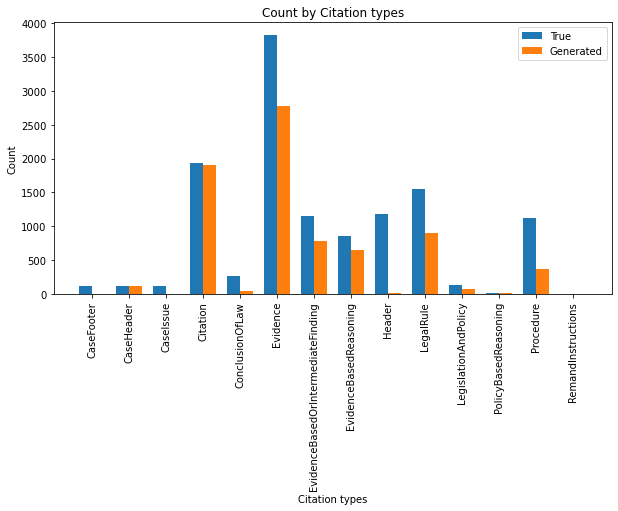

In [78]:
labels = ['CaseFooter', 'CaseHeader', 'CaseIssue', 'Citation', 'ConclusionOfLaw', 'Evidence', 'EvidenceBasedOrIntermediateFinding', 'EvidenceBasedReasoning', 
          'Header', 'LegalRule', 'LegislationAndPolicy', 'PolicyBasedReasoning', 'Procedure', 'RemandInstructions']
all_count_values = list(all_count.values())
pred_count_values = list(pred_true_count.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, all_count_values, width, label='True')
rects2 = ax.bar(x + width/2, pred_count_values, width, label='Generated')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Citation types')
ax.set_title('Count by Citation types')
ax.legend()

def autolabel(rects,c):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '%d' % int(height),
                ha='center', va='bottom', color=c, rotation = '45')

#autolabel(rects1, 'gray')
#autolabel(rects2, 'orange')

tickvalues = range(0,len(x)) 
plt.xticks(ticks = tickvalues ,labels = labels, rotation = 'vertical')

plt.rcParams["figure.figsize"] = (10,5)

plt.show()

2.2 Improved segmentation analysis

In [79]:
nlp = spacy.load("en_core_web_sm")

In [80]:
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case(u'Pub L. No.', [{ORTH: u'Pub L. No.'}])
nlp.tokenizer.add_special_case(u'Veterans Affairs (VA)', [{ORTH: u'Veterans Affairs (VA)'}])
nlp.tokenizer.add_special_case(u'Regional Office (RO)', [{ORTH: u'Regional Office (RO)'}])
nlp.tokenizer.add_special_case(u'Fed. Reg.', [{ORTH: u'Fed. Reg.'}])
nlp.tokenizer.add_special_case(u'Fed. Cir.', [{ORTH: u'Fed. Cir.'}])

In [81]:
pred_annotations=[]

for id in train_documents_by_id:
    plainText = train_documents_by_id[id]['plainText']
    #plainText = plainText.replace("\\s+", " ") # multiple spaces
    doc = nlp(plainText)
    for sent in doc.sents:
        str_sent = str(sent)
        annotation={
            'document':id,
            'end':sent.end_char,
            'start':sent.start_char,
            'txt':str_sent
        }
        pred_annotations.append(annotation)

In [82]:
pred_annotations[0]

{'document': '61aea55c97ad59b4cfc4129d',
 'end': 86,
 'start': 0,
 'txt': 'Citation Nr: 0640279\t\r\nDecision Date: 12/29/06    Archive Date: 01/05/07\r\n\r\nDOCKET NO.'}

In [83]:
#with open(directory+'pred_annotations_improved.pickle', 'wb') as handle:
#    pickle.dump(pred_annotations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [84]:
#with open(directory+'pred_annotations_improved.pickle', 'rb') as handle:
#    pred_annotations = pickle.load(handle)

Error Analysis

In [85]:
true_annotations = train_spans.copy()
len(train_spans)

12361

In [86]:
true_positive = 0
true_positive_annotations = []

for k in range(10):
    for i in true_annotations:
        for j in pred_annotations:
            if i['document']==j['document'] and abs(i['start']-j['start'])<=3: #and abs(i['end']-j['end'])<=3:
                true_positive+=1
                true_positive_annotations.append(i)
                true_annotations.remove(i)
                pred_annotations.remove(j)
    print(true_positive)

4562
6657
7490
7651
7665
7665
7665
7665
7665
7665


In [87]:
false_negative = len(true_annotations)
false_positive = len(pred_annotations)
precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive+false_negative)
F1=2*(precision*recall)/(precision+recall)
print("Accross all training data\nTrue Positive: ", true_positive,
      "\nFalse Negative: ", false_negative,
      "\nFalse Positive: ", false_positive,
      "\nPrecision: ", precision,
      "\nRecall: ", recall,
      "\nF1 score: ", F1)

Accross all training data
True Positive:  7665 
False Negative:  4696 
False Positive:  3877 
Precision:  0.664096343787905 
Recall:  0.6200954615322385 
F1 score:  0.6413420909509266


In [88]:
# document level error metrics
doc_ids = list(set([s['document'] for s in train_spans]))

error_per_doc = {}

for i in doc_ids:
    TP = len([true_positive_annotations[j] for j in range(len(true_positive_annotations)) if true_positive_annotations[j]['document']==i])
    FN = len([true_annotations[j] for j in range(len(true_annotations)) if true_annotations[j]['document']==i])
    FP = len([pred_annotations[j] for j in range(len(pred_annotations)) if pred_annotations[j]['document']==i])
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    doc_error = {
        'TP': TP,
        'FN': FN,
        'FP': FP,
        'precision': precision,
        'recall': recall,
        'F1': 2*(precision*recall)/(precision+recall)
    }
    error_per_doc[i] = doc_error

len(error_per_doc)

113

In [89]:
f1s = sorted((error_per_doc[doc]['F1'] for doc in error_per_doc),reverse = False)

print("Lowest F1 score 1: ", f1s[0],
      "\nLowest F1 score 2: ", f1s[1],
      "\nLowest F1 score 3: ", f1s[2],
      "\nHighest F1 score: ", f1s[112])

Lowest F1 score 1:  0.35555555555555557 
Lowest F1 score 2:  0.3939393939393939 
Lowest F1 score 3:  0.43636363636363634 
Highest F1 score:  0.7514450867052023


In [90]:
lowest1_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[0]][0]
lowest2_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[1]][0]
lowest3_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[2]][0]
highest_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[112]][0]
print(lowest1_id,lowest2_id,lowest3_id,highest_id)

61aea55e97ad59b4cfc412f0 61aea55c97ad59b4cfc412ae 61aea55e97ad59b4cfc412de 61aea57497ad59b4cfc413d1


2.3 Law-specific sentence segmenter

In [ ]:
#os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')

In [91]:
import luima_sbd.sbd_utils

In [92]:
pred_annotations=[]
regex = re.compile(r'[\t\r\n]')

for id in train_documents_by_id:
    plainText = train_documents_by_id[id]['plainText']

    plainText.encode('latin-1','ignore') 
    plainText=regex.sub(" ", plainText)
    plainText = plainText.replace("\\s+", " ") # remove multiple spaces

    annotations = luima_sbd.sbd_utils.text2sentences(plainText) 
    annotation_offset = luima_sbd.sbd_utils.text2sentences(plainText, offsets=True)
    annotations_start=[e[0] for e in annotation_offset]
    annotations_end=[e[1] for e in annotation_offset]

    for i in range(len(annotations)):
        annotation={
        'document':id,
        'end':annotations_end[i],
        'start':annotations_start[i],
        'txt':annotations[i]
        }
        pred_annotations.append(annotation)

len(pred_annotations)

12432

In [93]:
pred_annotations[0]

{'document': '61aea55c97ad59b4cfc4129d',
 'end': 46,
 'start': 0,
 'txt': 'Citation Nr: 0640279   Decision Date: 12/29/06'}

In [94]:
#with open(directory+'pred_annotations_lumina.pickle', 'wb') as handle:
#    pickle.dump(pred_annotations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
#with open(directory+'pred_annotations_lumina.pickle', 'rb') as handle:
#    pred_annotations = pickle.load(handle)

Error Analysis

In [96]:
true_annotations = train_spans.copy()
len(train_spans)

12361

In [97]:
true_positive = 0
true_positive_annotations = []

for k in range(10):
    for i in true_annotations:
        for j in pred_annotations:
            if i['document']==j['document'] and abs(i['start']-j['start'])<=3:# and abs(i['end']-j['end'])<=3:
                true_positive+=1
                true_positive_annotations.append(i)
                true_annotations.remove(i)
                pred_annotations.remove(j)
    print(true_positive)

6049
9036
10503
11221
11566
11719
11785
11804
11804
11804


In [98]:
false_negative = len(true_annotations)
false_positive = len(pred_annotations)
precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive+false_negative)
F1=2*(precision*recall)/(precision+recall)
print("Accross all training data\nTrue Positive: ", true_positive,
      "\nFalse Negative: ", false_negative,
      "\nFalse Positive: ", false_positive,
      "\nPrecision: ", precision,
      "\nRecall: ", recall,
      "\nF1 score: ", F1)

Accross all training data
True Positive:  11804 
False Negative:  557 
False Positive:  628 
Precision:  0.9494851994851995 
Recall:  0.9549389207992881 
F1 score:  0.9522042511999355


In [99]:
# document level error metrics
doc_ids = list(set([s['document'] for s in train_spans]))

error_per_doc = {}

for i in doc_ids:
    TP = len([true_positive_annotations[j] for j in range(len(true_positive_annotations)) if true_positive_annotations[j]['document']==i])
    FN = len([true_annotations[j] for j in range(len(true_annotations)) if true_annotations[j]['document']==i])
    FP = len([pred_annotations[j] for j in range(len(pred_annotations)) if pred_annotations[j]['document']==i])
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    doc_error = {
      'TP': TP,
      'FN': FN,
      'FP': FP,
      'precision': precision,
      'recall': recall,
      'F1': 2*(precision*recall)/(precision+recall)
    }
    error_per_doc[i] = doc_error

len(error_per_doc)

113

In [100]:
f1s = sorted((error_per_doc[doc]['F1'] for doc in error_per_doc),reverse = False)

print("Lowest F1 score 1: ", f1s[0],
      "\nLowest F1 score 2: ", f1s[1],
      "\nLowest F1 score 3: ", f1s[2],
      "\nHighest F1 score: ", f1s[112])

Lowest F1 score 1:  0.7924528301886793 
Lowest F1 score 2:  0.838709677419355 
Lowest F1 score 3:  0.8992248062015504 
Highest F1 score:  0.9852507374631269


In [101]:
lowest1_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[0]][0]
lowest2_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[1]][0]
lowest3_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[2]][0]
highest_id = [doc for doc in error_per_doc if error_per_doc[doc]['F1']==f1s[112]][0]
print(lowest1_id,lowest2_id,lowest3_id,highest_id)

61aea55e97ad59b4cfc412f0 61aea55f97ad59b4cfc41336 61aea55e97ad59b4cfc412ee 61aea57497ad59b4cfc413e9


In [113]:
error_per_doc['61aea57497ad59b4cfc413e9']

{'TP': 167,
 'FN': 3,
 'FP': 2,
 'precision': 0.9881656804733728,
 'recall': 0.9823529411764705,
 'F1': 0.9852507374631269}

In [114]:
#false_negative = len(true_annotations) doğru olması gereken ama beceremediklerim
#false_positive = len(pred_annotations) yanlış yaptıklarım
#true_positive_annotations doğru yaptıklarım

doc1 = [i for i in true_annotations if i['document']=='61aea57497ad59b4cfc413e9']
doc1

[{'txt': 'THE ISSUE',
  'document': '61aea57497ad59b4cfc413e9',
  'type': 'Header',
  'start': 208,
  'start_normalized': 0.00794317574276331,
  'end': 217,
  'outcome': 'denied'},
 {'txt': 'ATTORNEY FOR THE BOARD',
  'document': '61aea57497ad59b4cfc413e9',
  'type': 'Header',
  'start': 432,
  'start_normalized': 0.01649736500420072,
  'end': 454,
  'outcome': 'denied'},
 {'txt': 'VA may grant service connection for disability resulting from disease or injury incurred in or aggravated by active duty.',
  'document': '61aea57497ad59b4cfc413e9',
  'type': 'LegalRule',
  'start': 10646,
  'start_normalized': 0.4065531199877797,
  'end': 10767,
  'outcome': 'denied'}]

In [110]:
doc1 = [i for i in true_positive_annotations if i['document']=='61aea55f97ad59b4cfc41336']
doc1

[{'txt': "____________________________________________\r\nKATHLEEN K. GALLAGHER\r\nVeterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\nDepartment of Veterans Affairs\r",
  'document': '61aea55f97ad59b4cfc41336',
  'type': 'CaseFooter',
  'start': 18087,
  'start_normalized': 0.9912857612627425,
  'end': 18241,
  'outcome': 'granted'},
 {'txt': 'Service Connection - Hearing Loss \r',
  'document': '61aea55f97ad59b4cfc41336',
  'type': 'Header',
  'start': 2800,
  'start_normalized': 0.15345829222843363,
  'end': 2835,
  'outcome': 'granted'},
 {'txt': '\r\nFINDINGS OF FACT\r',
  'document': '61aea55f97ad59b4cfc41336',
  'type': 'Header',
  'start': 1588,
  'start_normalized': 0.08703277430669736,
  'end': 1607,
  'outcome': 'granted'},
 {'txt': 'REPRESENTATION\r',
  'document': '61aea55f97ad59b4cfc41336',
  'type': 'Header',
  'start': 291,
  'start_normalized': 0.015948701085169353,
  'end': 306,
  'outcome': 'granted'},
 {'txt': 'Appellant represented by:\tDisabled American 

In [115]:
doc1 = [i for i in pred_annotations if i['document']=='61aea57497ad59b4cfc413e9']
doc1

[{'document': '61aea57497ad59b4cfc413e9',
  'end': 72,
  'start': 50,
  'txt': 'Archive Date: 04/26/16'},
 {'document': '61aea57497ad59b4cfc413e9',
  'end': 112,
  'start': 76,
  'txt': 'DOCKET NO.  12-17 771 ) DATE   )   )'}]

In [116]:
all_count = {'CaseFooter': len([d['type'] for d in train_spans if d['type']=='CaseFooter']), 
              'CaseHeader': len([d['type'] for d in train_spans if d['type']=='CaseHeader']), 
              'CaseIssue': len([d['type'] for d in train_spans if d['type']=='CaseIssue']), 
              'Citation': len([d['type'] for d in train_spans if d['type']=='Citation']), 
              'ConclusionOfLaw': len([d['type'] for d in train_spans if d['type']=='ConclusionOfLaw']), 
              'Evidence': len([d['type'] for d in train_spans if d['type']=='Evidence']), 
              'EvidenceBasedOrIntermediateFinding': len([d['type'] for d in train_spans if d['type']=='EvidenceBasedOrIntermediateFinding']), 
              'EvidenceBasedReasoning': len([d['type'] for d in train_spans if d['type']=='EvidenceBasedReasoning']), 
              'Header': len([d['type'] for d in train_spans if d['type']=='Header']), 
              'LegalRule': len([d['type'] for d in train_spans if d['type']=='LegalRule']), 
              'LegislationAndPolicy': len([d['type'] for d in train_spans if d['type']=='LegislationAndPolicy']), 
              'PolicyBasedReasoning': len([d['type'] for d in train_spans if d['type']=='PolicyBasedReasoning']), 
              'Procedure': len([d['type'] for d in train_spans if d['type']=='Procedure']), 
              'RemandInstructions': len([d['type'] for d in train_spans if d['type']=='RemandInstructions'])
              }
pred_true_count = {'CaseFooter': len([d['type'] for d in true_positive_annotations if d['type']=='CaseFooter']), 
              'CaseHeader': len([d['type'] for d in true_positive_annotations if d['type']=='CaseHeader']), 
              'CaseIssue': len([d['type'] for d in true_positive_annotations if d['type']=='CaseIssue']), 
              'Citation': len([d['type'] for d in true_positive_annotations if d['type']=='Citation']), 
              'ConclusionOfLaw': len([d['type'] for d in true_positive_annotations if d['type']=='ConclusionOfLaw']), 
              'Evidence': len([d['type'] for d in true_positive_annotations if d['type']=='Evidence']), 
              'EvidenceBasedOrIntermediateFinding': len([d['type'] for d in true_positive_annotations if d['type']=='EvidenceBasedOrIntermediateFinding']), 
              'EvidenceBasedReasoning': len([d['type'] for d in true_positive_annotations if d['type']=='EvidenceBasedReasoning']), 
              'Header': len([d['type'] for d in true_positive_annotations if d['type']=='Header']), 
              'LegalRule': len([d['type'] for d in true_positive_annotations if d['type']=='LegalRule']), 
              'LegislationAndPolicy': len([d['type'] for d in true_positive_annotations if d['type']=='LegislationAndPolicy']), 
              'PolicyBasedReasoning': len([d['type'] for d in true_positive_annotations if d['type']=='PolicyBasedReasoning']), 
              'Procedure': len([d['type'] for d in true_positive_annotations if d['type']=='Procedure']), 
              'RemandInstructions': len([d['type'] for d in true_positive_annotations if d['type']=='RemandInstructions'])
              }

The following snipppet is adjusted from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

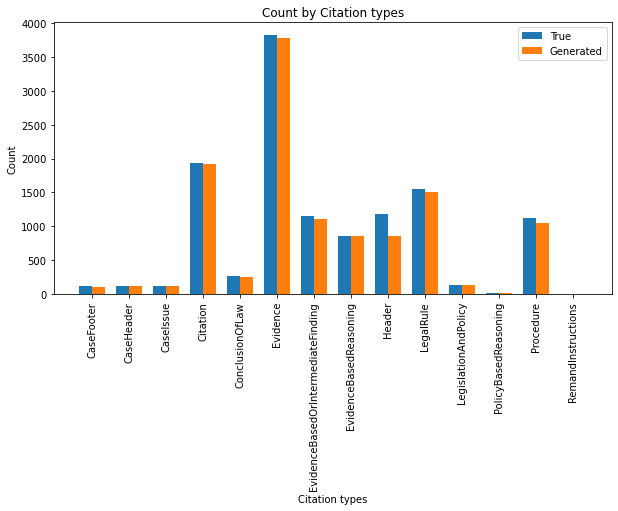

In [117]:
labels = ['CaseFooter', 'CaseHeader', 'CaseIssue', 'Citation', 'ConclusionOfLaw', 'Evidence', 'EvidenceBasedOrIntermediateFinding', 'EvidenceBasedReasoning', 
          'Header', 'LegalRule', 'LegislationAndPolicy', 'PolicyBasedReasoning', 'Procedure', 'RemandInstructions']
all_count_values = list(all_count.values())
pred_count_values = list(pred_true_count.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, all_count_values, width, label='True')
rects2 = ax.bar(x + width/2, pred_count_values, width, label='Generated')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Citation types')
ax.set_title('Count by Citation types')
ax.legend()

def autolabel(rects,c):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '%d' % int(height),
                ha='center', va='bottom', color=c, rotation = '45')

#autolabel(rects1, 'gray')
#autolabel(rects2, 'orange')

tickvalues = range(0,len(x)) 
plt.xticks(ticks = tickvalues ,labels = labels, rotation = 'vertical')

plt.rcParams["figure.figsize"] = (10,5)

plt.show()

### Phase 3: Preprocessing

3.1 Splitting unlabeled data

In [ ]:
#os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')

In [118]:
import luima_sbd.sbd_utils

In [ ]:
filenames= os.listdir(directory+'unlabeled/')
len(filenames)

In [ ]:
#takes around 7-10 minutes
unlabeled_data=[]
filenames= os.listdir(directory+'unlabeled/')

for i in filenames:  
    with open(os.path.join(directory+'unlabeled/', i),encoding='latin-1') as f:
        content = f.read()
        data={
          'document':i[0:-4],
          'plainText': content
        }
        unlabeled_data.append(data)

In [ ]:
len(unlabeled_data)

In [ ]:
unlabeled_data[0:3]

In [ ]:
#with open(directory+'unlabeled_data.pickle', 'wb') as handle:
#    pickle.dump(unlabeled_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [144]:
with open(directory+'unlabeled_data.pickle', 'rb') as handle:
    unlabeled_data = pickle.load(handle)

In [ ]:
from multiprocessing import Process

unlabeled_annotations=[]
regex = re.compile(r'[\t\r\n]')

def func1():
      for id in range(0,5000):
        plainText = unlabeled_data[id]['plainText']
        plainText.encode('latin-1','ignore') 
        plainText=regex.sub(" ", plainText)
        plainText = plainText.replace("\\s+", " ") # multiple spaces

        annotations = luima_sbd.sbd_utils.text2sentences(plainText) 

        for i in range(len(annotations)):
            annotation={
        'document':unlabeled_data[id]['document'],
        'txt':annotations[i]
      }
            unlabeled_annotations.append(annotation)

def func2():
    for id in range(5000,10000):
        plainText = unlabeled_data[id]['plainText']
        plainText.encode('latin-1','ignore') 
        plainText=regex.sub(" ", plainText)
        plainText = plainText.replace("\\s+", " ") # multiple spaces

        annotations = luima_sbd.sbd_utils.text2sentences(plainText) 

        for i in range(len(annotations)):
            annotation={
            'document':unlabeled_data[id]['document'],
            'txt':annotations[i]
            }
            unlabeled_annotations.append(annotation)

def func3():
      for id in range(10000,15000):
        plainText = unlabeled_data[id]['plainText']
        plainText.encode('latin-1','ignore') 
        plainText=regex.sub(" ", plainText)
        plainText = plainText.replace("\\s+", " ") # multiple spaces

        annotations = luima_sbd.sbd_utils.text2sentences(plainText) 

        for i in range(len(annotations)):
            annotation={
        'document':unlabeled_data[id]['document'],
        'txt':annotations[i]
      }
            unlabeled_annotations.append(annotation)

def func4():
    for id in range(15000,20000):
        plainText = unlabeled_data[id]['plainText']
        plainText.encode('latin-1','ignore') 
        plainText=regex.sub(" ", plainText)
        plainText = plainText.replace("\\s+", " ") # multiple spaces

        annotations = luima_sbd.sbd_utils.text2sentences(plainText) 

        for i in range(len(annotations)):
            annotation={
            'document':unlabeled_data[id]['document'],
            'txt':annotations[i]
            }
            unlabeled_annotations.append(annotation)

def func5():
      for id in range(20000,25000):
        plainText = unlabeled_data[id]['plainText']
        plainText.encode('latin-1','ignore') 
        plainText=regex.sub(" ", plainText)
        plainText = plainText.replace("\\s+", " ") # multiple spaces

        annotations = luima_sbd.sbd_utils.text2sentences(plainText) 

        for i in range(len(annotations)):
            annotation={
        'document':unlabeled_data[id]['document'],
        'txt':annotations[i]
      }
            unlabeled_annotations.append(annotation)

def func6():
    for id in range(25000,30002):
        plainText = unlabeled_data[id]['plainText']
        plainText.encode('latin-1','ignore') 
        plainText=regex.sub(" ", plainText)
        plainText = plainText.replace("\\s+", " ") # multiple spaces

        annotations = luima_sbd.sbd_utils.text2sentences(plainText) 

        for i in range(len(annotations)):
            annotation={
            'document':unlabeled_data[id]['document'],
            'txt':annotations[i]
            }
            unlabeled_annotations.append(annotation)

processes = []

p1 = Process(target=func1(), args=())
processes.append(p1)
print('process appended: 1')

p2 = Process(target=func2(), args=())
processes.append(p2)
print('process appended: 2')

p3 = Process(target=func3(), args=())
processes.append(p3)
print('process appended: 3')

p4 = Process(target=func4(), args=())
processes.append(p4)
print('process appended: 4')

p5 = Process(target=func5(), args=())
processes.append(p5)
print('process appended: 5')

p6 = Process(target=func6(), args=())
processes.append(p6)
print('process appended: 6')

for p in processes:
    p.start()

for p in processes:
    p.join()

len(unlabeled_annotations)

In [ ]:
#with open(directory+'unlabeled_annotations.pickle', 'wb') as handle:
#    pickle.dump(unlabeled_annotations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [120]:
with open(directory+'unlabeled_annotations.pickle', 'rb') as handle:
     unlabeled_annotations = pickle.load(handle)

In [121]:
len(unlabeled_annotations)

2786990

Plot a histogram for the number of sentences across all unlabeled decisions

The following code snippet is from the LDSI WS2021-2022 Text Classification Workshop

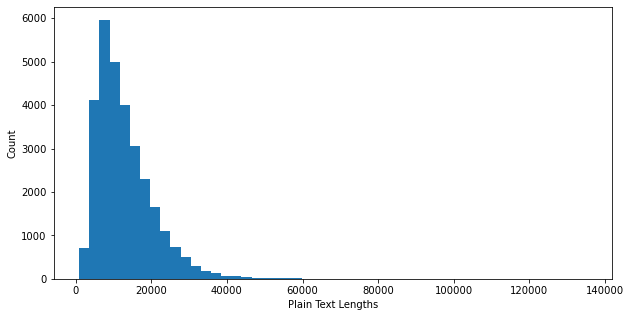

In [122]:
doc_lengths = [len(d['plainText']) for d in unlabeled_data]
doc_lengths = [n for n in doc_lengths if n > 0]
plt.xlabel('Plain Text Lengths')
plt.ylabel('Count')
plt.hist(doc_lengths, bins=50)
plt.show()

In [ ]:
doc_num_annos = [len([a for a in unlabeled_annotations if a['document'] == unlabeled_data[i]['document']])
                 for i in range(len(unlabeled_data))]
doc_num_annos = [n for n in doc_num_annos if n > 0]
plt.xlabel('Number of sentences')
plt.ylabel('Count')
plt.hist(doc_num_annos, bins=100)
plt.show()

In [ ]:
#with open(directory+'doc_num_annos.pickle', 'wb') as handle:
#    pickle.dump(doc_num_annos, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [123]:
with open(directory+'doc_num_annos.pickle', 'rb') as handle:
     doc_num_annos = pickle.load(handle)

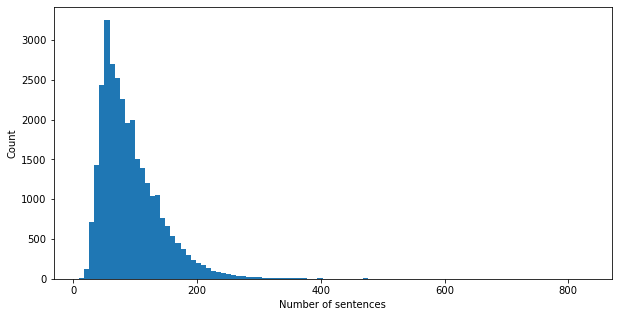

In [124]:
plt.xlabel('Number of sentences')
plt.ylabel('Count')
plt.hist(doc_num_annos, bins=100)
plt.show()

In [ ]:
ann_df = pd.DataFrame(unlabeled_annotations)

In [ ]:
ann_df.head(5)

3.2 Sentence-wise preprocessing

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes('parser') #disable parser for faster computation
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [ ]:
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case(u'Pub L. No.', [{ORTH: u'Pub L. No.'}])
nlp.tokenizer.add_special_case(u'Veterans Affairs (VA)', [{ORTH: u'Veterans Affairs (VA)'}])
nlp.tokenizer.add_special_case(u'Regional Office (RO)', [{ORTH: u'Regional Office (RO)'}])
nlp.tokenizer.add_special_case(u'Fed. Reg.', [{ORTH: u'Fed. Reg.'}])
nlp.tokenizer.add_special_case(u'Fed. Cir.', [{ORTH: u'Fed. Cir.'}])

The following code snippet is adjusted from the LDSI WS2021-2022 Text Classification Workshop



In [ ]:
def spacy_tokenize(lst):
    #multiprocessing with spacy https://spacy.io/usage/processing-pipelines
    count = 0
    for doc in nlp.pipe(lst, disable=["parser"], n_process=12):
        clean_tokens = []
        
        tokens = list(doc)
    
        for t in tokens:
            if t.pos_ == 'PUNCT': #treat punctuation consistently
                pass
            elif t.pos_ == 'NUM': #simplify numbers
                clean_tokens.append(f'<NUM{len(t)}>') 
            if str(t) not in stop_words:
                t_= str(t.lemma_)
                t_ = t_.encode('ascii', 'ignore').decode('utf-8', 'ignore') #remove all non ascii characters
                t_ = t_.lower() #lowercase everything
                if len(t_)>0 and t_ not in string.punctuation and t_!=' ' and t_ not in stop_words and t_!='  ': 
                    t_ = re.sub(r'[^a-zA-Z0-9]', '', t_) #remove all non alphanumeric chars
                    if t_.isnumeric():
                        clean_tokens.append(f'<NUM{len(t_)}>') 
                    else:
                        clean_tokens.append(t_)
                    
        unlabeled_annotations[count]['tokens_spacy']=clean_tokens
        count+=1
        
def single_file(spans):
    single_file = ""
    for s in spans:
        single_line = ""
        if len(s['tokens_spacy'])>5:
            for i in range(len(s['tokens_spacy'])):
                single_line += s['tokens_spacy'][i]+" "
        if len(single_line)>0:
            single_file += single_line+"\n"

    return single_file

In [ ]:
#Random sentence example tokenization
ex1 = "This matter came before the Board of Veterans' Appeals  (Board) on appeal from a decision of July 1999 by the  Department of Veterans Affairs (VA) Columbia, South Carolina  Regional Office (RO)."
ex2 = "A clear rationale for all opinions would be helpful and a discussion of the facts and medical principles involved would be of considerable assistance to the Board."
ex3 = "The Veteran submitted additional evidence to the Board in May 2014."

In [ ]:
def spacy_tokenize(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        elif str(t) not in stop_words:
            t_= str(t.lemma_)
            t_ = t_.encode('ascii', 'ignore').decode('utf-8', 'ignore') #remove all non ascii characters
            t_ = t_.lower() #lowercase everything
            if len(t_)>0 and t_ not in string.punctuation and t_!=' ' and t_ not in stop_words and t_!='  ':
                t_ = re.sub(r'[^a-zA-Z0-9]', '', t_) #remove all non alphanumeric chars
                if t_.isnumeric():
                    clean_tokens.append(f'<NUM{len(t_)}>') 
                else:
                    clean_tokens.append(t_)
    return clean_tokens

In [ ]:
spacy_tokenize(ex1)

In [ ]:
spacy_tokenize(ex2)

In [ ]:
spacy_tokenize(ex3)

3.3 Tokenize unlabeled data

In [ ]:
#takes aroud x minutes 07:57
nlp = spacy.load("en_core_web_sm")
unlabeled_spans = [s['txt'] for s in unlabeled_annotations]
spacy_tokenize(unlabeled_spans)

In [ ]:
#with open(directory+'unlabeled_spans_with_stop_words_and_empty.pickle', 'wb') as handle:
#    pickle.dump(unlabeled_annotations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [174]:
with open(directory+'unlabeled_spans.pickle', 'rb') as handle:
     unlabeled_annotations = pickle.load(handle)

In [175]:
len(unlabeled_annotations)

2786990

Plot a histogram of number of tokens in each sentence for
the unlabeled data

The following code snippet is from the LDSI WS2021-2022 Text Classification Workshop

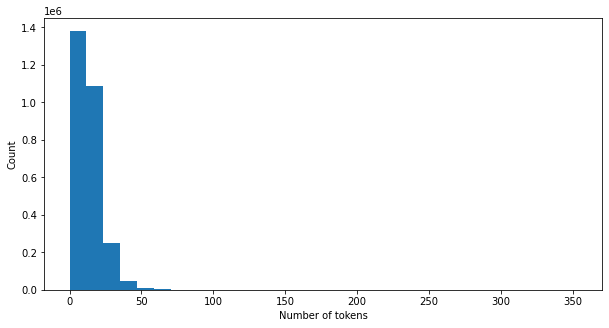

In [176]:
span_lengths_spacy = [len(s['tokens_spacy']) for s in unlabeled_annotations]
plt.hist(span_lengths_spacy, bins=30)
plt.xlabel('Number of tokens')
plt.ylabel('Count')
plt.show()

In [137]:
total_num_tokens = np.sum(span_lengths_spacy)
total_num_tokens

37198064

In [133]:
total_num_tokens = np.sum(span_lengths_spacy)
total_num_tokens

66531260

In [ ]:
text_file = open("Single_File.txt", "w")

random.shuffle(unlabeled_annotations)
content = single_file(unlabeled_annotations)

text_file.write(content)
text_file.close()

### Phase 4: Developing Word Embeddings

4.1 Custom FastText embeddings

In [ ]:
#os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')

In [ ]:
#!git clone https://github.com/facebookresearch/fastText.git
#%cd fastText
#!python3 setup.py install

In [ ]:
#%cd fastText

In [ ]:
#!pip install .

In [ ]:
import fasttext

Implementation from https://radimrehurek.com/gensim/models/fasttext.html

In [ ]:
#import gensim
#from gensim.models import FastText    
#(718539389, 929951600)
#(718546571, 929951600)

import fasttext

model = fasttext.FastText.fasttext(vector_size=100, window=3, min_count=20)  

span_tokens = [unlabeled_annotations[i]['tokens_spacy'] for i in range(len(unlabeled_annotations))]

model.build_vocab(span_tokens)

#takes around 30 minutes
model.train(span_tokens, total_examples=len(span_tokens), epochs=25)

In [ ]:
import fasttext  
#takes around 30 minutes 17:30
model = fasttext.train_unsupervised(directory+"Single_File.txt", min_count=20, minn=2, epoch=25)

In [ ]:
#model.save_model(directory+"fasttext.model")

In [33]:
import fasttext  
model = fasttext.load_model(directory+"fasttext.model")

In [ ]:
dir(model)

4.2 Evaluating Custom Embeddings Manually


In [140]:
total_words = len(model.words)
print("Total number of words in the corpus: ", total_words) # 37198064, 13219

Total number of words in the corpus:  13219


In [141]:
model.words[0:10]

['</s>',
 '<NUM4>',
 'veteran',
 'service',
 '<NUM2>',
 'evidence',
 "'s",
 'board',
 '<NUM3>',
 'claim']

In [142]:
model.get_word_vector("veteran")

array([-0.38011262,  0.14189859,  0.28440303,  0.03114906,  0.08934076,
        0.23032548,  0.09135454, -0.20754863, -0.14771752, -0.1492177 ,
        0.08842837, -0.06465978,  0.08763659, -0.2715037 , -0.2110233 ,
       -0.05011488, -0.21919225,  0.03291421,  0.03000885, -0.36329025,
        0.02434235,  0.10204123,  0.20125382, -0.05752978, -0.10279599,
       -0.00671681, -0.09608854,  0.10561371, -0.04731899, -0.3093733 ,
       -0.17030713,  0.11334028, -0.11398054,  0.05373243, -0.01943148,
        0.04895789,  0.41346315,  0.00822926, -0.1688338 ,  0.10240042,
        0.03559208,  0.24796848,  0.10652974,  0.17468812, -0.25598183,
        0.18693434,  0.28818935,  0.16768183, -0.09660333,  0.2528126 ,
       -0.10311371, -0.01326822, -0.24621798, -0.27063686, -0.19711217,
       -0.08358403, -0.20912495,  0.18773301, -0.03628922,  0.00888878,
       -0.2630517 , -0.09424628,  0.36589676,  0.11588082,  0.1405115 ,
       -0.11938868, -0.04599412,  0.16008371, -0.12870254,  0.04

In [143]:
model.get_nearest_neighbors("veteran")

[(0.7458277940750122, 'appellant'),
 (0.6957507729530334, "'s"),
 (0.6052248477935791, 'additionally'),
 (0.5947623252868652, 'furthermore'),
 (0.5861455798149109, 'wife'),
 (0.5684086680412292, 's.k.c.'),
 (0.5667195916175842, 'spouse'),
 (0.5642572045326233, 'moreover'),
 (0.5397050380706787, 'board'),
 (0.538973867893219, 'r.m.k.')]

In [148]:
model.get_word_vector("v.") 

array([-0.11543051,  0.33797795,  0.30857265,  0.5393936 ,  0.08198693,
       -0.35934204, -0.278421  , -0.20468675, -0.17077534,  0.02193978,
        0.04928625,  0.1166026 , -0.43007126,  0.49101394, -0.03130392,
       -0.06738189, -0.5857012 ,  0.06473611,  0.3072742 ,  0.08198354,
       -0.20687611,  0.07734531, -0.401489  , -0.38568273, -0.3925173 ,
       -0.425984  ,  0.2684513 ,  0.06026606, -0.6989508 , -0.08095287,
        0.10615693,  0.02755903,  0.37346643, -0.5412776 , -0.69102967,
       -0.14851394,  0.09287051,  0.149364  ,  0.22491296,  0.7047266 ,
        0.5666054 ,  0.18110971,  0.08770643, -0.22963616, -0.31841084,
        0.4990229 ,  0.22927456, -0.47094572,  0.1891622 , -0.16357847,
       -0.11265509,  0.9239994 ,  0.16869126,  0.21454397, -0.10224283,
        0.85870224, -0.6618169 ,  0.49440944,  0.09746163, -0.06239285,
        0.36304793,  0.30876395,  0.06819197,  0.8684208 ,  0.1970038 ,
       -0.37566742, -0.24280967, -0.5802765 , -0.3053354 ,  0.34

In [149]:
model.get_nearest_neighbors("v.")

[(0.9711394906044006, 'vet'),
 (0.9685329794883728, 'app'),
 (0.8085377812385559, 'nicholson'),
 (0.7902422547340393, 'brown'),
 (0.789401650428772, 'f.3d'),
 (0.7664183378219604, 'supra'),
 (0.7620198726654053, 'cir'),
 (0.7547886967658997, 'principi'),
 (0.7502326965332031, '<NUM3>'),
 (0.7463566660881042, 'derwinski')]

In [150]:
model.get_word_vector("argues") 

array([-0.19669303, -0.16611378,  0.44233474, -0.06802743,  0.020921  ,
        0.26908162, -0.2027248 , -0.12595432, -0.20985618, -0.7333476 ,
        0.12514597, -0.19496213, -0.25202715,  0.07645081,  0.01274851,
        0.23912098,  0.29729906, -0.02762762,  0.38559607, -0.3117098 ,
       -0.3638926 , -0.10793868, -0.12260561,  0.04832314, -0.21113065,
       -0.2902407 , -0.05724063,  0.32652694,  0.35375357, -0.11221639,
       -0.25239655, -0.17930657,  0.17388679, -0.48790732, -0.21392639,
       -0.27584004, -0.13715795,  0.3607525 , -0.21317421,  0.07397905,
        0.39834517,  0.29276636,  0.34127223, -0.11801261, -0.20840585,
        0.4493945 ,  0.5422509 ,  0.3657717 ,  0.12599397,  0.0169657 ,
       -0.02598556,  0.45718697, -0.27002463, -0.11377012, -0.10055641,
        0.23790507, -0.42670155, -0.00811256, -0.31897807,  0.26577923,
       -0.04117286,  0.18651786,  0.2895176 ,  0.45666945, -0.15485457,
       -0.25885907,  0.27488253,  0.16977772,  0.08384331, -0.28

In [151]:
model.get_nearest_neighbors("argues")

[(0.6492365598678589, 'argue'),
 (0.609191358089447, 'appealed'),
 (0.5862430930137634, 'amvets'),
 (0.5845062732696533, 'kathy'),
 (0.5744639039039612, 'ihp'),
 (0.5735241174697876, 'holbrook'),
 (0.5632197260856628, 'journet'),
 (0.5626943111419678, 'issues'),
 (0.561785101890564, 'skow'),
 (0.5585602521896362, 'carolyn')]

In [152]:
model.get_word_vector("ptsd") 

array([ 0.02938086,  0.07780624,  0.27895817,  0.4522888 ,  0.12475982,
        0.02595991,  0.2775095 , -0.04214158,  0.0993925 , -0.11520043,
        0.3055599 , -0.674389  ,  0.19655414, -0.29112005,  0.18290955,
        0.14976948, -0.47668076, -0.00831965,  0.13570423, -0.2269264 ,
       -0.28045338, -0.18422803, -0.24264653, -0.06612793, -0.14724281,
        0.21081525, -0.23261823, -0.2558943 ,  0.08768512, -0.54651487,
       -0.19863166, -0.18093604, -0.00246986,  0.23924899, -0.1959696 ,
       -0.16659681, -0.07067086,  0.16925742, -0.42075595, -0.19847463,
        0.17327815,  0.5574696 , -0.1935721 , -0.35547096, -0.4534947 ,
        0.3163518 ,  0.32744285, -0.22008178, -0.11634846,  0.28643894,
        0.2940961 ,  0.25499892, -0.29882342, -0.11551615,  0.4664095 ,
       -0.12564084,  0.5065859 , -0.0024448 ,  0.23927934,  0.29354572,
       -0.15916136,  0.06371635,  0.4069079 ,  0.06503979, -0.03544956,
        0.07911402,  0.6375688 ,  0.02758285, -0.56656474,  0.26

In [153]:
model.get_nearest_neighbors("ptsd")

[(0.7484529614448547, 'pstd'),
 (0.7432765364646912, 'depressive'),
 (0.7311574816703796, 'mdd'),
 (0.7098116874694824, 'anxiety'),
 (0.7088505029678345, 'mst'),
 (0.7073091864585876, 'psychiatric'),
 (0.7016343474388123, 'stressor'),
 (0.6902839541435242, 'dsm'),
 (0.6820942759513855, 'depression'),
 (0.6774406433105469, 'dysthymic')]

In [154]:
model.get_word_vector("granted") 

array([ 0.63922626, -0.26059112,  0.39900523,  0.2200572 ,  0.09096599,
       -0.4815765 ,  0.5039555 , -0.14151621,  0.1086389 , -0.4023538 ,
       -0.29316017, -0.446143  , -0.3279712 ,  0.6783007 , -0.13950972,
       -0.10728556, -0.05677817, -0.18154572,  0.39795214, -0.22274184,
        0.09898853,  0.28176382,  0.23214984,  0.08193281,  0.23168851,
        0.12166867, -0.21108475,  0.08911965, -0.15116142, -0.3539905 ,
       -0.213004  , -0.10587067, -0.09605771, -0.10656183, -0.43972898,
        0.06769916, -0.00737722, -0.290038  , -0.3151811 ,  0.08140287,
        0.6995646 ,  0.43818608, -0.08917914,  0.04020925, -0.54558897,
        0.22186925,  0.5911218 ,  0.09872437, -0.18944053, -0.38484356,
        0.44204494,  0.10131779, -0.57924753,  0.21987854,  0.17513974,
       -0.01960392,  0.01147762, -0.31982622, -0.22928233,  0.2696308 ,
       -0.3549494 ,  0.09048761,  0.01132804, -0.06972376, -0.001408  ,
       -0.03888394,  0.14356911,  0.07463577, -0.18168531, -0.20

In [155]:
model.get_nearest_neighbors("granted")

[(0.6491292715072632, 'unwarranted'),
 (0.6323496699333191, 'granting'),
 (0.6146053075790405, 'grant'),
 (0.5253406763076782, 'moot'),
 (0.5097670555114746, 'fundamental'),
 (0.5038952827453613, 'bifurcate'),
 (0.5018612742424011, 'fundamentally'),
 (0.4942259192466736, 'negate'),
 (0.484470397233963, 'attribution'),
 (0.48435571789741516, 'unrebutted')]

In [156]:
model.get_word_vector("korea") 

array([ 0.02296961, -0.26706922,  0.09707462, -0.3360891 , -0.17873578,
        0.6425582 ,  0.2897163 , -0.37806398, -0.5137246 , -0.00975245,
        0.38588473, -0.38107696, -0.02726278,  0.25463966,  0.06439166,
        0.19138879, -0.2569599 ,  0.01826246,  0.03287742,  0.06116698,
       -0.21223965, -0.33573338,  0.2798843 ,  0.05039988, -0.3911161 ,
       -0.5191112 ,  0.2327722 , -0.25426164,  0.28114483, -0.47584677,
       -0.1069071 , -0.10199523, -0.14960918,  0.7872581 ,  0.04693652,
       -0.08402049,  0.2050117 ,  0.47503617, -0.01217378, -0.283931  ,
       -0.11568043,  0.4179971 , -0.3002381 , -0.1836459 , -0.41811332,
        0.24846783,  0.06639332,  0.7076202 ,  0.26056215,  0.1953254 ,
        0.31842363, -0.27985466, -0.28438726, -0.18387483, -0.75322455,
        0.05715201, -0.37894848,  0.02013049, -0.36562994,  0.73137903,
       -0.0518853 ,  0.61907154,  0.12831497,  0.01971638, -0.11092468,
       -0.13925587,  0.34020567,  0.09555458, -0.2891822 ,  0.38

In [157]:
model.get_nearest_neighbors("korea")

[(0.8464919924736023, 'korean'),
 (0.8220942616462708, 'demilitarized'),
 (0.8208914995193481, 'dmz'),
 (0.8057577610015869, 'demilitarize'),
 (0.7534998655319214, 'germany'),
 (0.7460004687309265, 'station'),
 (0.7235473394393921, 'vietnam'),
 (0.7111783623695374, 'infantry'),
 (0.7085801959037781, 'seoul'),
 (0.7075814604759216, 'panama')]

In [158]:
model.get_word_vector("vietnam") 

array([ 3.4825289e-01, -6.1785411e-02,  7.6249670e-03,  1.7042194e-01,
       -1.7146215e-01,  3.6043212e-01,  1.9015191e-01, -6.4720589e-01,
       -4.4370148e-01,  1.9817100e-01,  3.2650122e-01, -2.9002163e-01,
       -1.6689758e-01, -2.2725859e-01, -4.9471304e-02,  1.6754054e-02,
       -1.0917706e-02, -2.5274047e-01,  4.0189424e-01, -7.9236045e-02,
       -2.2363213e-01, -2.3004673e-01,  3.5997052e-02, -3.7584606e-01,
       -6.0449976e-01, -4.5703247e-01, -2.7561468e-01,  4.4590313e-02,
        6.6276306e-01, -2.8818038e-01, -3.6409136e-02,  8.0320835e-02,
       -4.5463887e-01,  4.1913387e-01, -8.9446902e-02, -5.5285847e-01,
        3.4593421e-03,  1.4805232e-01,  8.2593382e-04, -3.3056918e-01,
       -2.6100636e-01,  2.5116107e-01, -1.5652925e-01, -4.0557358e-02,
       -4.5935783e-01,  2.3208410e-01,  9.0142660e-02,  6.5452945e-01,
        1.3007516e-01,  3.2380271e-01,  4.6998072e-01, -1.8283136e-01,
       -6.1407197e-01, -1.3713624e-01, -5.2566606e-01,  1.8638045e-01,
      

In [159]:
model.get_nearest_neighbors("vietnam")

[(0.8990875482559204, 'republic'),
 (0.828021228313446, 'rvn'),
 (0.8243981003761292, 'era'),
 (0.7616826891899109, 'country'),
 (0.7235475778579712, 'korea'),
 (0.7198407053947449, 'nam'),
 (0.7169238924980164, 'korean'),
 (0.7020124197006226, 'danang'),
 (0.6912425756454468, 'thailand'),
 (0.688798725605011, 'visitation')]

In [160]:
model.get_word_vector("holding") 

array([-0.33932668,  0.3910213 ,  0.53218365,  0.5310906 , -0.13395092,
       -0.22072604,  0.20341657, -0.00516961, -0.02138755, -0.29694864,
       -0.19517405, -0.05852618, -0.68769526,  0.356935  ,  0.08955756,
       -0.11727553,  0.07636298, -0.05310277,  0.58002234, -0.3322469 ,
        0.23206705, -0.12051535, -0.4902776 , -0.25179708, -0.617505  ,
        0.21645513,  0.20031716, -0.37979797,  0.05493546, -0.65720826,
        0.0143046 , -0.3759549 ,  0.16910242, -0.01636035, -0.4499131 ,
       -0.15523438,  0.22206071, -0.25754365, -0.1075366 ,  0.65579516,
        0.2918557 ,  0.02307281, -0.2792912 , -0.26004443, -0.6109177 ,
       -0.2413953 ,  0.8045309 , -0.21473934,  0.34618232,  0.00232904,
       -0.01653791,  0.37623408, -0.38989395,  0.5518301 , -0.2648779 ,
        0.58027875, -0.2903552 ,  0.33914998,  0.6526786 , -0.25425178,
        0.39873323,  0.31894916,  0.24406907,  0.3402121 ,  0.34173825,
       -0.06943926,  0.4261882 , -0.19889121,  0.06697212,  0.33

In [161]:
model.get_nearest_neighbors("holding")

[(0.6680654883384705, 'supra'),
 (0.6420727372169495, 'ruling'),
 (0.5795372128486633, 'dingess'),
 (0.5698583722114563, 'court'),
 (0.5626428723335266, 'cavc'),
 (0.5611292719841003, 'precedent'),
 (0.5601937770843506, 'clemons'),
 (0.5600301027297974, 'hartman'),
 (0.5395931005477905, 'app'),
 (0.5389542579650879, 'v.')]

In [162]:
model.get_word_vector("also") 

array([ 1.38308302e-01,  4.83606160e-02,  1.66732967e-01,  2.66369998e-01,
        1.33457839e-01, -1.55037925e-01, -1.95096340e-02, -2.94892564e-02,
        6.62121251e-02,  7.37813115e-03,  2.21892595e-02, -3.17740023e-01,
       -8.64426419e-02, -1.67970750e-02, -1.64024070e-01, -2.00848252e-01,
       -2.11367100e-01, -7.39546567e-02,  2.84070134e-01,  4.99576330e-02,
       -1.40726268e-02,  8.82996619e-02, -1.67944402e-01,  1.65947244e-01,
        1.64347172e-01, -1.49344623e-01,  3.26499343e-04,  1.43277481e-01,
        2.11105272e-02, -8.29160511e-02,  1.06722862e-03,  3.35090458e-01,
       -2.34970167e-01,  1.99038163e-02, -2.57905900e-01, -2.53058791e-01,
        2.95058191e-01,  3.42630148e-01,  1.02251455e-01,  3.08666289e-01,
       -2.74714082e-03,  4.05027233e-02,  2.81599730e-01, -1.63820699e-01,
       -1.18567407e-01,  5.11361837e-01,  1.84101731e-01, -1.79558486e-01,
       -5.49941622e-02,  2.07082272e-01, -2.81683743e-01,  7.71653503e-02,
       -1.26411378e-01,  

In [163]:
model.get_nearest_neighbors("also")

[(0.6741060018539429, 'see'),
 (0.587733268737793, '<NUM4>'),
 (0.5825441479682922, '<NUM3>'),
 (0.5822994112968445, 'addition'),
 (0.5698255896568298, 'supra'),
 (0.5585245490074158, 'id.'),
 (0.5338320732116699, 'atd'),
 (0.5327028036117554, 'v.'),
 (0.5301550030708313, '<NUM2>'),
 (0.5294107794761658, 'cir.1996')]

3 more strings

In [164]:
model.get_word_vector("apnea") 

array([ 0.09466612, -0.24177118,  0.08030479,  0.50260496, -0.07845218,
        0.45725173,  0.15270996, -0.00885222, -0.02824844,  0.18087325,
        0.12552199, -0.34128577, -0.33474565, -0.3029978 ,  0.3182607 ,
        0.07258837, -0.35047984, -0.08851004,  0.23387587, -0.16203602,
       -0.39085343, -0.05370071,  0.19806531, -0.2403941 ,  0.11298877,
        0.32610577, -0.3242639 ,  0.20628682,  0.00951042, -0.71562004,
        0.14118484,  0.362411  ,  0.13813518, -0.3462779 , -0.1529569 ,
       -0.35849616,  0.2760666 ,  0.3362686 ,  0.07800546,  0.00692879,
        0.27030656,  0.3993441 ,  0.4530676 , -0.2358658 ,  0.5680537 ,
        0.90244395,  0.22240949,  0.62220323,  0.09664068,  0.3677666 ,
       -0.26089528,  0.07174899, -0.10125818,  0.3928635 ,  0.07162984,
        0.09603173,  0.7271572 ,  0.00738389,  0.32149604,  0.20018966,
       -0.35320598,  0.02945912, -0.02597995,  0.0211482 , -0.16596912,
       -0.4762664 ,  0.37159586,  0.32927626, -0.14587232,  0.18

In [165]:
model.get_nearest_neighbors("apnea")

[(0.9144460558891296, 'sleep'),
 (0.8939564228057861, 'osa'),
 (0.8575782775878906, 'obstructive'),
 (0.7877780199050903, 'narcolepsy'),
 (0.7576891183853149, 'hypopnea'),
 (0.7526936531066895, 'snore'),
 (0.7450331449508667, 'rhinitis'),
 (0.7257040143013, 'sleepiness'),
 (0.7164373993873596, 'somnolence'),
 (0.7142280340194702, 'hypersomnolence')]

In [166]:
model.get_word_vector("denied") 

array([-0.3083342 , -0.6567991 ,  0.3875821 ,  0.3986543 , -0.10093755,
        0.09278226, -0.44140014,  0.10554877,  0.4051026 ,  0.06553259,
        0.41158992, -0.6057999 , -0.5305049 ,  0.26482153,  0.18114151,
        0.17836113, -0.2987233 , -0.44458267, -0.03001281, -0.2146128 ,
       -0.17735751,  0.25946042,  0.10288329,  0.19339104, -0.0879254 ,
       -0.55899197, -0.03463944, -0.06231037, -0.15427686, -0.7139935 ,
        0.21586315, -0.41800785,  0.42164084, -0.4191712 , -0.25419995,
       -0.29276058,  0.2512338 ,  0.33730432,  0.23763609,  0.07567565,
        0.4570467 ,  0.1617591 ,  0.49902278,  0.16210395, -0.5407379 ,
        0.1944031 , -0.08832581, -0.05601413,  0.35827082,  0.36191294,
        0.45697108, -0.2064158 , -0.45521414,  0.26867548,  0.09963475,
       -0.43476576, -0.39229664, -0.05610146, -0.05829638,  0.54986966,
       -0.05342283,  0.05198048,  0.48402724,  0.63025606,  0.29634956,
       -0.3971431 ,  0.20644903, -0.5106948 , -0.27919388, -0.36

In [167]:
model.get_nearest_neighbors("denied")

[(0.7480729222297668, 'unaccompanied'),
 (0.6173006892204285, 'buchanan'),
 (0.5969694256782532, 'nicolson'),
 (0.5880629420280457, 'rasputnis'),
 (0.578528642654419, 'maxon'),
 (0.5754420757293701, 'moshiashwili'),
 (0.573436439037323, 'klekar'),
 (0.572300374507904, 'senyk'),
 (0.5720195174217224, 'zevalkink'),
 (0.5689389705657959, 'donnie')]

In [168]:
model.get_word_vector("tinnitus") 

array([ 0.3052904 , -0.32892886,  0.07774273,  0.11140178,  0.19580606,
        0.28490603,  0.37901393, -0.2762145 , -0.07683168,  0.01553824,
        0.18480392, -0.16507716, -0.4344677 ,  0.11921737,  0.37147918,
        0.1711366 , -0.08033559, -0.5854714 ,  0.57533306, -0.34743974,
       -0.2622016 ,  0.0156925 ,  0.2989599 ,  0.01281547, -0.2564473 ,
        0.16364533,  0.9025347 ,  0.03203271,  0.10062353, -0.28621212,
       -0.13667934, -0.12760437,  0.05689515, -0.08773346, -0.30170864,
       -0.09958562,  0.08260072,  0.10098607,  0.13290027,  0.1868278 ,
       -0.22394477,  0.10168699,  0.4143657 , -0.04829621,  0.23895104,
       -0.16632403, -0.02792995, -0.24555843, -0.21094313,  0.78610957,
        0.01689805,  0.06921031, -0.29537657, -0.06913669,  0.20117171,
       -0.01933663,  0.1156114 ,  0.16249658,  0.3639905 , -0.06548335,
       -0.21349475,  0.41392013,  0.1981755 ,  0.40551445,  0.25489607,
       -0.37206462, -0.0612319 ,  0.32604188, -0.16384704,  0.35

In [169]:
model.get_nearest_neighbors("tinnitus")

[(0.8239877820014954, 'tinnitu'),
 (0.7730292081832886, 'acoustic'),
 (0.7661648392677307, 'noise'),
 (0.7514041066169739, 'loss'),
 (0.7396038174629211, 'meniere'),
 (0.7288179993629456, 'vertigo'),
 (0.7058738470077515, 'ringing'),
 (0.6839337944984436, 'ear'),
 (0.6833410859107971, 'buzzing'),
 (0.6789208650588989, 'buzz')]

### Phase 5: Training Classifiers

5.1 TFIDF featurization

The following code snippets are taken from Text Classification workshop

In [34]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iremg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case(u'Pub L. No.', [{ORTH: u'Pub L. No.'}])
nlp.tokenizer.add_special_case(u'Veterans Affairs (VA)', [{ORTH: u'Veterans Affairs (VA)'}])
nlp.tokenizer.add_special_case(u'Regional Office (RO)', [{ORTH: u'Regional Office (RO)'}])
nlp.tokenizer.add_special_case(u'Fed. Reg.', [{ORTH: u'Fed. Reg.'}])
nlp.tokenizer.add_special_case(u'Fed. Cir.', [{ORTH: u'Fed. Cir.'}])

In [36]:
def spacy_tokenize3(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            t_ = t.lemma_.encode('ascii', 'ignore').decode('utf-8', 'ignore')
            t_ = t_.lower()
            t_ = re.sub(r'[^a-zA-Z0-9]', '', t_)
            if t_ not in stop_words:
                clean_tokens.append(t_)
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize3(s['txt'])

In [37]:
spans_add_spacy_tokens(train_spans)
spans_add_spacy_tokens(dev_spans)
spans_add_spacy_tokens(test_spans)

Credit for code goes to [buhrmann.github.io](https://buhrmann.github.io/tfidf-analysis.html)

In [37]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs


def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

#SKL version: do not run
train_vectorizer = TfidfVectorizer(min_df=5)
train_vectorizer = train_vectorizer.fit(train_spans_txt)
train_tfidf_features_skl = train_vectorizer.get_feature_names()

dev_vectorizer = TfidfVectorizer(min_df=5)
dev_vectorizer = dev_vectorizer.fit(dev_spans_txt)
dev_tfidf_features_skl = dev_vectorizer.get_feature_names()

test_vectorizer = TfidfVectorizer(min_df=5)
test_vectorizer = dev_vectorizer.fit(test_spans_txt)
test_tfidf_features_skl = test_vectorizer.get_feature_names()

#
train_tfidf_skl = train_vectorizer.transform(train_spans_txt).toarray()
dev_tfidf_skl = train_vectorizer.transform(dev_spans_txt).toarray()
test_tfidf_skl = train_vectorizer.transform(test_spans_txt).toarray()

train_spans_labels = np.array([s['type'] for s in train_spans])
dev_spans_labels = np.array([s['type'] for s in dev_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])

#
span_top_tfidf(train_spans_txt, train_tfidf_skl,tfidf_features_skl,random.randint(0, len(train_spans)))

#
dfs = top_features_by_class(train_tfidf_skl, train_spans_labels,tfidf_features_skl)
#
dfs.keys()

#
dfs['Citation']

In [ ]:
# suboptimal: tokenizer gets called twice
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenize3, min_df=3, ngram_range=(1,1))
spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_spans_txt)
tfidf_features_spacy = spacy_tfidf_vectorizer.get_feature_names()

In [ ]:
#with open(directory+'spacy_tfidf_vectorizer.pickle', 'wb') as handle:
#    pickle.dump(spacy_tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open(directory+'spacy_tfidf_vectorizer.pickle', 'rb') as handle:
     spacy_tfidf_vectorizer = pickle.load(handle)

In [ ]:
vectorizer = spacy_tfidf_vectorizer.transform(train_spans_txt).toarray()

train_spans_labels = np.array([s['type'] for s in train_spans])

In [ ]:
span_top_tfidf(train_spans_txt, 
               vectorizer,
               tfidf_features_spacy,
               random.randint(0, len(train_spans)))

In [ ]:
dfs = top_features_by_class(vectorizer, 
                            train_spans_labels,
                            tfidf_features_spacy)

In [ ]:
dfs.keys()

In [ ]:
dfs['CaseHeader']

5.2 Word Embedding Featurization 

An average of the embedding vectors for the tokens in the sentence (with the same
dimension as the embedding model)

In [39]:
def average_embedding_vector(spans):
    avg_lst = []
    for i in range(len(spans)): #for each sentence
        vec_sum = 0
        for j in range(len(spans[i]['tokens_spacy'])): #for each token
            vec_sum = vec_sum + model.get_word_vector(spans[i]['tokens_spacy'][j])
            #vec_sum = vec_sum + np.sum(model.get_word_vector(spans[i]['tokens_spacy'][j]))
        vec_avg = vec_sum/len(spans[i]['tokens_spacy'])
        avg_lst.append(vec_avg)
    return avg_lst

A single float variable representing the number of tokens in the sentence, normalized
by subtracting the mean and dividing by the standard deviation across all sentence
tokens counts in the training data

In [128]:
def get_mean_and_std(spans):
    length_list = [len(i['tokens_spacy']) for i in spans]
    total_sum = np.sum(length_list)
    mean = total_sum / len(length_list)
    
    deviation = 0
    for i in range(len(length_list)):
        deviation = deviation + (length_list[i] - mean) ** 2
    
    deviation = deviation / (len(length_list)-1)
    deviation = math.sqrt(deviation)
    
    return mean, deviation

In [41]:
def normalized_vector(spans, mean, deviation):
    length_list = [len(i['tokens_spacy']) for i in spans]
    for i in range(len(length_list)):
        length_list[i] = (length_list[i] - mean)/deviation
    
    return length_list

The following code snippet is extended from Text Classification workshop

In [42]:
def make_feature_vectors_and_labels_tfidf(spans, spacy_tfidf_vectorizer):
    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    Y = np.array([s['type'] for s in spans])
    X = tfidf
    return X, Y

In [43]:
def make_feature_vectors_and_labels_embedding(spans, mean, deviation):
    average_vector = np.array(average_embedding_vector(spans))
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    normalized_lst = normalized_vector(spans, mean, deviation)
    Y = np.array([s['type'] for s in spans])
    X = np.concatenate((average_vector,
                        np.expand_dims(starts_normalized, axis=1),
                        np.expand_dims(normalized_lst, axis=1)), axis=1)
    return X, Y

5.3 Model Training

In [44]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [45]:
def prediction_errors_tfidf(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_feature_vectors_and_labels_tfidf(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [226]:
def prediction_errors_embedding(clf, eval_spans, eval_X, eval_y, 
                      select_true_label=None, 
                      select_pred_label=None):
    #eval_X, eval_y = make_feature_vectors_and_labels_embedding(eval_spans, mean, deviation)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [47]:
len(train_spans)

12378

In [48]:
train_spans = [s for s in train_spans if s['type']!='RemandInstructions']
len(train_spans)

12375

In [49]:
len(test_spans)

1334

In [50]:
test_spans = [s for s in test_spans if s['type']!='RemandInstructions']
len(test_spans)

1334

In [51]:
len(dev_spans)

1637

In [52]:
dev_spans = [s for s in dev_spans if s['type']!='RemandInstructions']
len(dev_spans)

1637

In [53]:
train_spans[0]['tokens_spacy'][0]

''

In [54]:
len(train_spans[0]['tokens_spacy'])

61

### Embedding based model

In [129]:
mean, deviation = get_mean_and_std(train_spans)

In [130]:
mean

14.470060606060606

In [131]:
deviation

10.726535457010293

In [132]:
with open(directory+'mean_and_deviation.pickle', 'wb') as handle:
    mean_and_deviation = [mean, deviation]
    pickle.dump(mean_and_deviation, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [133]:
with open(directory+'mean_and_deviation.pickle', 'rb') as handle:
    mean_and_deviation = pickle.load(handle)
    mean = mean_and_deviation[0]
    deviation = mean_and_deviation[1]

In [134]:
mean

14.470060606060606

In [135]:
deviation

10.726535457010293

In [136]:
train_X, train_Y = make_feature_vectors_and_labels_embedding(train_spans, mean, deviation)
test_X, test_Y = make_feature_vectors_and_labels_embedding(test_spans, mean, deviation)
dev_X, dev_Y = make_feature_vectors_and_labels_embedding(dev_spans, mean, deviation)

In [137]:
print(f'{train_X.shape} {train_Y.shape}')
print(f'{test_X.shape} {test_Y.shape}')
print(f'{dev_X.shape} {dev_Y.shape}')

(12375, 102) (12375,)
(1334, 102) (1334,)
(1637, 102) (1637,)


In [138]:
train_X = np.nan_to_num(train_X)

np.any(np.isnan(train_X))

False

In [139]:
np.all(np.isfinite(train_X))

True

In [140]:
test_X = np.nan_to_num(test_X)

np.any(np.isnan(test_X))

False

In [141]:
np.all(np.isfinite(test_X))

True

In [142]:
dev_X = np.nan_to_num(dev_X)

np.any(np.isnan(dev_X))

False

In [143]:
np.all(np.isfinite(dev_X))

True

In [144]:
train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])
dev_spans_labels = np.array([s['type'] for s in dev_spans])

Linear SVM

In [145]:
clf = SVC(gamma='auto', kernel='linear')
clf = clf.fit(train_X, train_Y)

In [146]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.93      0.99      0.96       114
                          Citation       0.98      0.99      0.98      1967
                   ConclusionOfLaw       0.85      0.81      0.83       272
                          Evidence       0.81      0.92      0.86      3727
EvidenceBasedOrIntermediateFinding       0.66      0.56      0.61      1189
            EvidenceBasedReasoning       0.52      0.28      0.36       852
                            Header       0.99      0.99      0.99      1180
                         LegalRule       0.81      0.88      0.85      1565
              LegislationAndPolicy       0.66      0.28      0.39       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


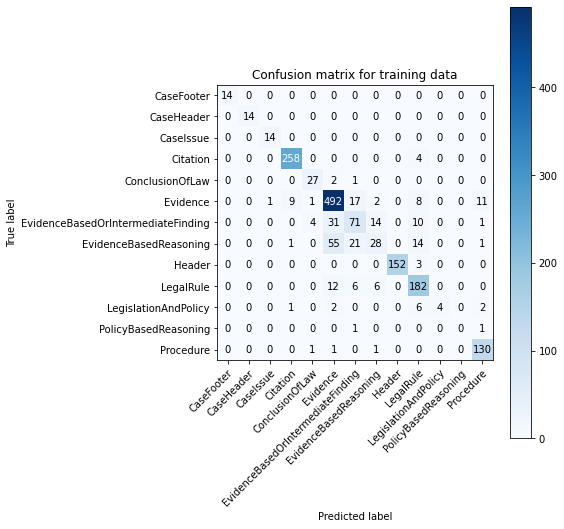

In [147]:
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

Logistic Regression

In [148]:
clf = LogisticRegression(random_state=0).fit(train_X, train_Y)

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [149]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.98      1.00      0.99       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.90      0.95      0.92       114
                          Citation       0.97      0.97      0.97      1967
                   ConclusionOfLaw       0.85      0.74      0.79       272
                          Evidence       0.80      0.91      0.85      3727
EvidenceBasedOrIntermediateFinding       0.64      0.53      0.58      1189
            EvidenceBasedReasoning       0.50      0.26      0.34       852
                            Header       0.98      0.99      0.98      1180
                         LegalRule       0.78      0.88      0.83      1565
              LegislationAndPolicy       0.65      0.27      0.38       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metr

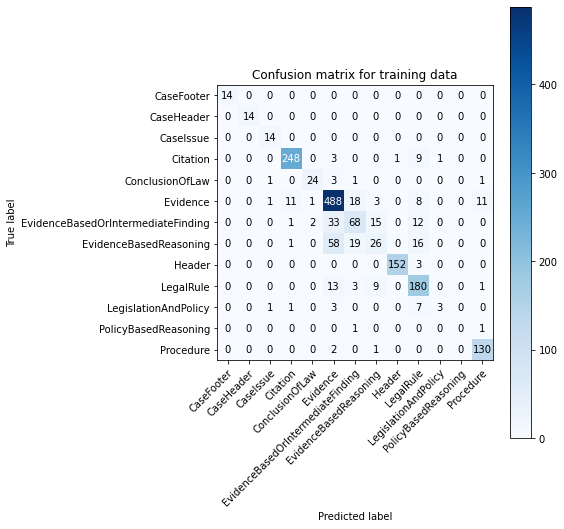

In [150]:
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

Radial/Polynomial kernel SVM

In [71]:
parameters = {'kernel':['poly'], 
              'C':[1, 10], 
              'degree':[3, 5], 
              'gamma': ['auto']
             }

In [72]:
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf = clf.fit(train_X, train_Y)
clf.best_params_

{'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

In [151]:
clf = SVC(gamma='auto', kernel='poly', degree=3, C=10)
clf = clf.fit(train_X, train_Y)

In [152]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.74      0.97      0.84       112
                        CaseHeader       0.00      0.00      0.00       115
                         CaseIssue       0.00      0.00      0.00       114
                          Citation       0.99      0.55      0.71      1967
                   ConclusionOfLaw       0.00      0.00      0.00       272
                          Evidence       0.36      1.00      0.53      3727
EvidenceBasedOrIntermediateFinding       0.00      0.00      0.00      1189
            EvidenceBasedReasoning       0.00      0.00      0.00       852
                            Header       0.99      0.54      0.70      1180
                         LegalRule       0.61      0.01      0.03      1565
              LegislationAndPolicy       0.00      0.00      0.00       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


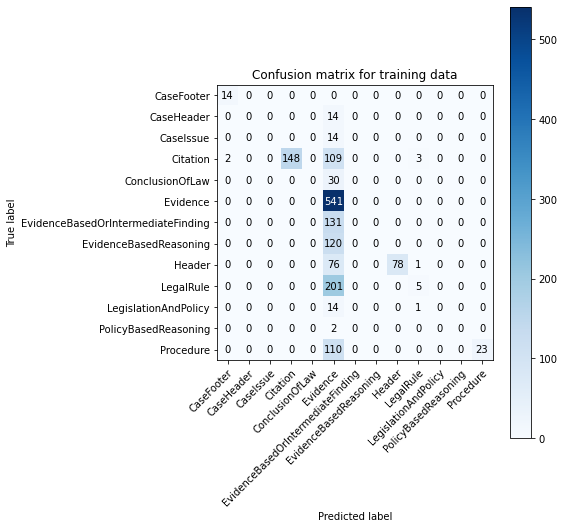

In [153]:
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

Decision Trees

In [ ]:
parameters = {'criterion':['gini', 'entropy'], 
              'max_depth':[5, 12], 
              'min_samples_split': [3, 5, 10],
              'splitter': ['best','random']
             }

In [ ]:
tree = tree.DecisionTreeClassifier()
clf = GridSearchCV(tree, parameters)
clf = clf.fit(train_X, train_Y)
clf.best_params_

In [154]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=12, min_samples_split=5, splitter='best')
clf = clf.fit(train_X, train_Y)

In [155]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.98      0.99       112
                        CaseHeader       0.98      1.00      0.99       115
                         CaseIssue       0.97      0.97      0.97       114
                          Citation       0.99      0.97      0.98      1967
                   ConclusionOfLaw       0.89      0.90      0.90       272
                          Evidence       0.80      0.94      0.87      3727
EvidenceBasedOrIntermediateFinding       0.76      0.61      0.68      1189
            EvidenceBasedReasoning       0.69      0.36      0.47       852
                            Header       1.00      0.98      0.99      1180
                         LegalRule       0.81      0.89      0.85      1565
              LegislationAndPolicy       0.84      0.50      0.62       143
              PolicyBasedReasoning       0.83      0.19      0.31        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


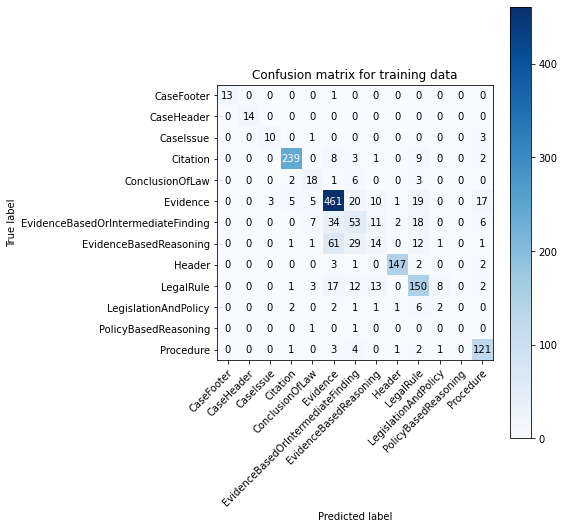

In [156]:
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

Random Forests

In [ ]:
parameters = {'criterion':['gini', 'entropy'], 
              'max_depth':[5, 12], 
              'min_samples_split': [3, 5, 10],
              'n_estimators': [100, 200]
             }

In [ ]:
forest = RandomForestClassifier()
clf = GridSearchCV(forest, parameters)
clf = clf.fit(train_X, train_Y)
clf.best_params_

In [157]:
clf = RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=12, min_samples_split=5)
clf = clf.fit(train_X, train_Y)

In [158]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       115
                         CaseIssue       0.99      0.99      0.99       114
                          Citation       1.00      0.99      0.99      1967
                   ConclusionOfLaw       0.99      0.96      0.98       272
                          Evidence       0.82      0.99      0.90      3727
EvidenceBasedOrIntermediateFinding       0.94      0.76      0.84      1189
            EvidenceBasedReasoning       0.99      0.45      0.62       852
                            Header       1.00      1.00      1.00      1180
                         LegalRule       0.94      0.96      0.95      1565
              LegislationAndPolicy       0.93      0.61      0.73       143
              PolicyBasedReasoning       1.00      0.27      0.42        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


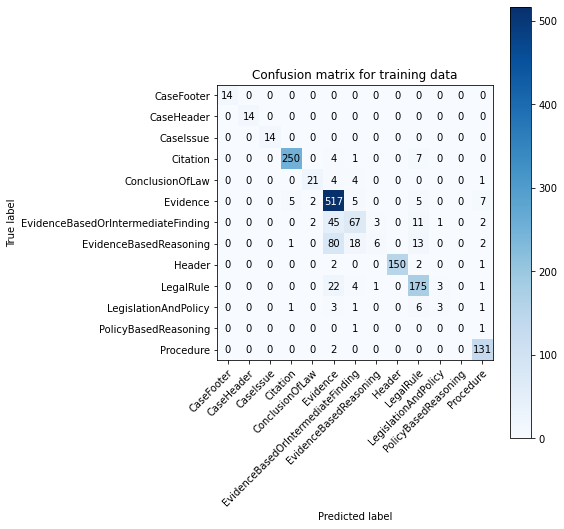

In [159]:
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

K-Nearest Neighbors

In [ ]:
parameters = {'n_neighbors':[5, 10, 13],
              'algorithm':['auto', 'kd_tree','brute'], 
              'metric':['minkowski', 'euclidean','wminkowski']
             }

In [ ]:
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf = clf.fit(train_X, train_Y)
clf.best_params_

In [160]:
clf = KNeighborsClassifier(n_neighbors=13,
                    algorithm='auto',
                    metric='minkowski')
clf = clf.fit(train_X, train_Y)

In [161]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.95      0.98      0.96       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.78      0.90      0.84       114
                          Citation       0.97      0.98      0.97      1967
                   ConclusionOfLaw       0.79      0.72      0.75       272
                          Evidence       0.76      0.94      0.84      3727
EvidenceBasedOrIntermediateFinding       0.63      0.54      0.58      1189
            EvidenceBasedReasoning       0.53      0.22      0.31       852
                            Header       0.98      0.97      0.98      1180
                         LegalRule       0.83      0.79      0.81      1565
              LegislationAndPolicy       0.61      0.22      0.32       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


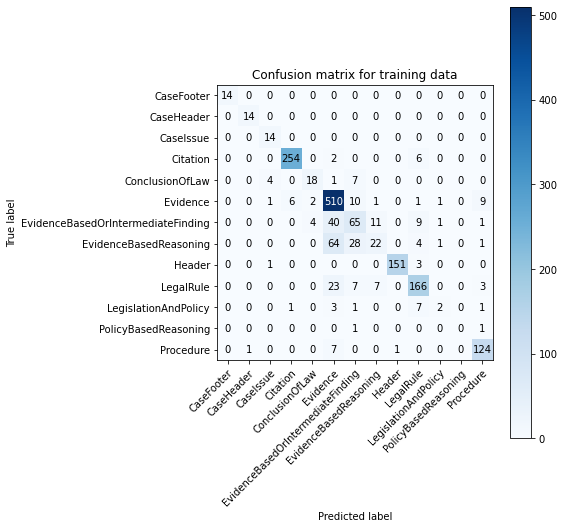

In [162]:
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

Multi-layer Perceptron

In [85]:
parameters = {'hidden_layer_sizes':[(100,),(200,),(400,)],
              'activation':['relu'],
              'solver':['adam'], 
              'batch_size':[256, 512], 
              'alpha':[0.0001, 0.001, 0.1, 1], 
              'learning_rate_init': [0.1, 0.01, 0.001],
              'early_stopping': [True],
              'shuffle': [True, False],
              'max_iter': [1000]
             }

In [86]:
neural = MLPClassifier()
clf = GridSearchCV(neural, parameters)
clf = clf.fit(train_X, train_Y)
clf.best_params_

{'activation': 'relu',
 'alpha': 0.1,
 'batch_size': 256,
 'early_stopping': True,
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.01,
 'max_iter': 1000,
 'shuffle': True,
 'solver': 'adam'}

In [163]:
clf = MLPClassifier(hidden_layer_sizes=(200,),
                    activation='relu',
                    solver='adam',
                    batch_size=256,
                    alpha=0.1,
                    warm_start=True,
                    shuffle=True,
                    learning_rate_init=0.01,
                    early_stopping=True,
                    max_iter=100)
clf = clf.fit(train_X, train_Y)

In [164]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.95      0.94      0.94       114
                          Citation       0.97      0.99      0.98      1967
                   ConclusionOfLaw       0.95      0.73      0.82       272
                          Evidence       0.86      0.90      0.88      3727
EvidenceBasedOrIntermediateFinding       0.67      0.65      0.66      1189
            EvidenceBasedReasoning       0.52      0.35      0.42       852
                            Header       0.99      0.99      0.99      1180
                         LegalRule       0.81      0.91      0.86      1565
              LegislationAndPolicy       0.67      0.27      0.38       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metr

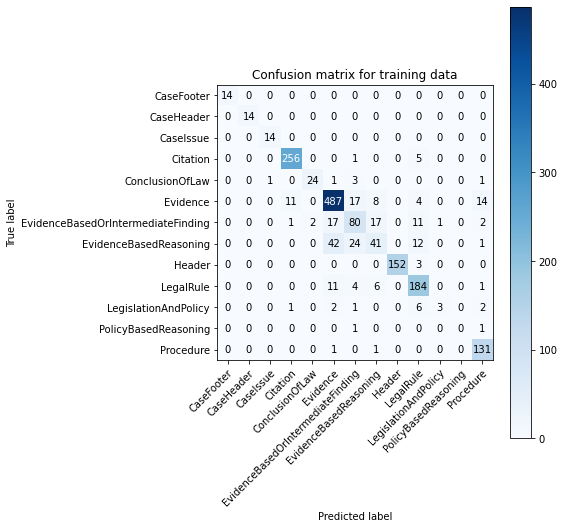

In [165]:
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

In [166]:
#with open(directory+'best_model_embedding.pickle', 'wb') as handle:
#    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [167]:
with open(directory+'best_model_embedding2.pickle', 'rb') as handle:
     clf_embedding = pickle.load(handle)    

### TFIDF based model

The following code snippets are taken from the Classification Workshop

In [93]:
train_X, train_Y = make_feature_vectors_and_labels_tfidf(train_spans, spacy_tfidf_vectorizer)
test_X, test_Y = make_feature_vectors_and_labels_tfidf(test_spans, spacy_tfidf_vectorizer)
dev_X, dev_Y = make_feature_vectors_and_labels_tfidf(dev_spans, spacy_tfidf_vectorizer)

In [94]:
print(f'{train_X.shape} {train_Y.shape}')
print(f'{test_X.shape} {test_Y.shape}')
print(f'{dev_X.shape} {dev_Y.shape}')

(12375, 3014) (12375,)
(1334, 3014) (1334,)
(1637, 3014) (1637,)


In [95]:
test_X = np.nan_to_num(test_X)
train_X = np.nan_to_num(train_X)
dev_X = np.nan_to_num(dev_X)

In [96]:
train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])
dev_spans_labels = np.array([s['type'] for s in dev_spans])

Linear SVM

In [98]:
clf2 = SVC(gamma='auto', kernel='linear')
clf2 = clf2.fit(train_X, train_Y)

In [99]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf2.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf2.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.94      0.99      0.97       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.90      0.99      0.94       114
                          Citation       0.99      0.98      0.98      1967
                   ConclusionOfLaw       0.91      0.87      0.89       272
                          Evidence       0.84      0.96      0.89      3727
EvidenceBasedOrIntermediateFinding       0.77      0.72      0.74      1189
            EvidenceBasedReasoning       0.74      0.40      0.52       852
                            Header       0.98      0.98      0.98      1180
                         LegalRule       0.87      0.93      0.90      1565
              LegislationAndPolicy       0.80      0.39      0.53       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


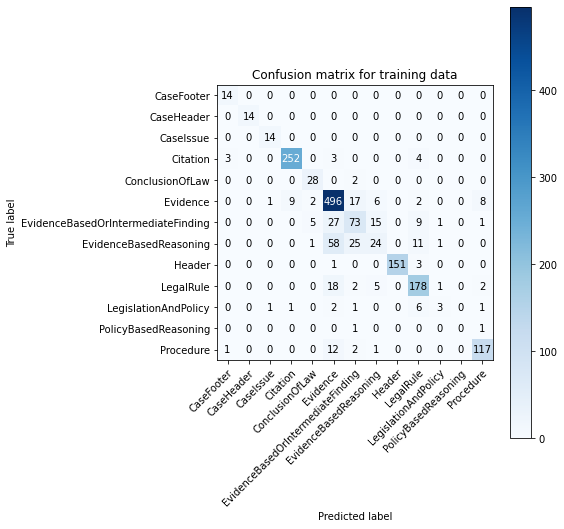

In [100]:
plot_confusion_matrix(dev_spans_labels, clf2.predict(dev_X), classes=list(clf2.classes_),
                      title='Confusion matrix for training data')
plt.show()

Logistic Regression

In [101]:
clf2 = LogisticRegression(random_state=0).fit(train_X, train_Y)

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [102]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf2.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf2.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metr

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.94      0.99      0.97       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.90      0.90      0.90       114
                          Citation       0.97      0.97      0.97      1967
                   ConclusionOfLaw       0.88      0.82      0.85       272
                          Evidence       0.80      0.95      0.87      3727
EvidenceBasedOrIntermediateFinding       0.76      0.67      0.71      1189
            EvidenceBasedReasoning       0.72      0.33      0.45       852
                            Header       0.98      0.97      0.97      1180
                         LegalRule       0.84      0.90      0.87      1565
              LegislationAndPolicy       0.78      0.24      0.37       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


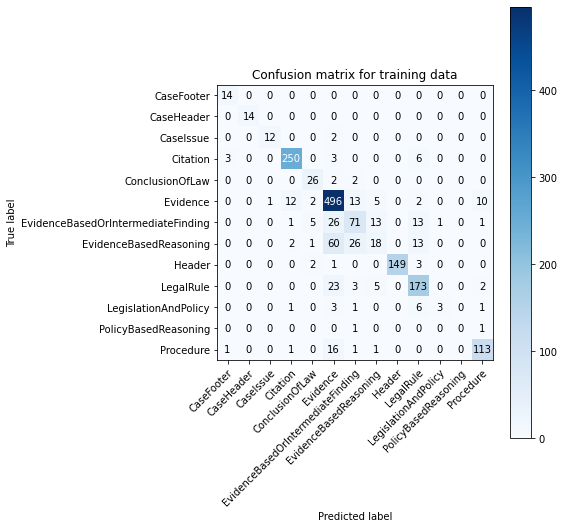

In [103]:
plot_confusion_matrix(dev_spans_labels, clf2.predict(dev_X), classes=list(clf2.classes_),
                      title='Confusion matrix for training data')
plt.show()

Radial/Polynomial kernel SVM

In [104]:
clf2 = SVC(gamma='auto', kernel='poly', degree=5)
clf2 = clf2.fit(train_X, train_Y)

In [105]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf2.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf2.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.00      0.00      0.00       112
                        CaseHeader       0.00      0.00      0.00       115
                         CaseIssue       0.00      0.00      0.00       114
                          Citation       0.00      0.00      0.00      1967
                   ConclusionOfLaw       0.00      0.00      0.00       272
                          Evidence       0.30      1.00      0.46      3727
EvidenceBasedOrIntermediateFinding       0.00      0.00      0.00      1189
            EvidenceBasedReasoning       0.00      0.00      0.00       852
                            Header       0.00      0.00      0.00      1180
                         LegalRule       0.00      0.00      0.00      1565
              LegislationAndPolicy       0.00      0.00      0.00       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


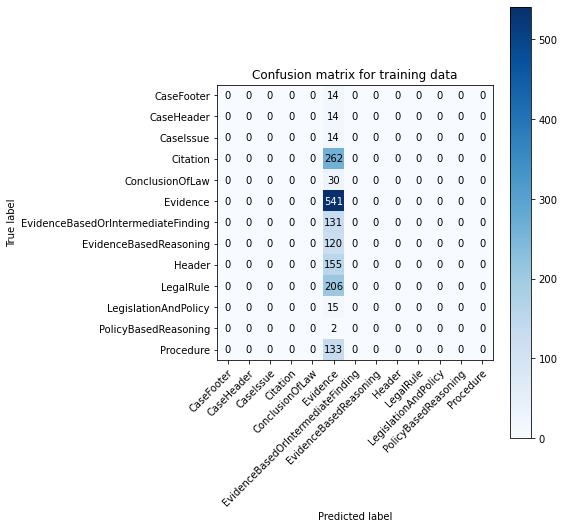

In [106]:
plot_confusion_matrix(dev_spans_labels, clf2.predict(dev_X), classes=list(clf2.classes_),
                      title='Confusion matrix for training data')
plt.show()

Decision Trees

In [107]:
clf2 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=12, min_samples_split=5, splitter='best')
clf2 = clf2.fit(train_X, train_Y)

In [108]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf2.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf2.predict(dev_X)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.89      0.96      0.92       114
                          Citation       0.98      0.96      0.97      1967
                   ConclusionOfLaw       0.82      0.65      0.73       272
                          Evidence       0.60      0.92      0.72      3727
EvidenceBasedOrIntermediateFinding       0.52      0.43      0.47      1189
            EvidenceBasedReasoning       0.46      0.14      0.22       852
                            Header       0.99      0.53      0.69      1180
                         LegalRule       0.74      0.66      0.69      1565
              LegislationAndPolicy       0.85      0.48      0.62       143
              PolicyBasedReasoning       1.00      0.19      0.32        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


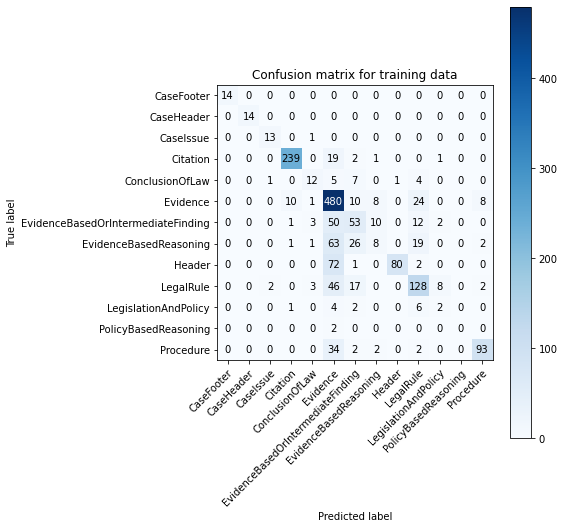

In [109]:
plot_confusion_matrix(dev_spans_labels, clf2.predict(dev_X), classes=list(clf2.classes_),
                      title='Confusion matrix for training data')
plt.show()

Random Forests

In [110]:
clf2 = RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=12, min_samples_split=5)
clf2 = clf2.fit(train_X, train_Y)

In [111]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf2.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf2.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metr

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.00      0.00      0.00       114
                          Citation       0.97      0.93      0.95      1967
                   ConclusionOfLaw       0.00      0.00      0.00       272
                          Evidence       0.43      1.00      0.60      3727
EvidenceBasedOrIntermediateFinding       0.92      0.08      0.14      1189
            EvidenceBasedReasoning       1.00      0.00      0.01       852
                            Header       0.99      0.29      0.44      1180
                         LegalRule       0.92      0.55      0.69      1565
              LegislationAndPolicy       0.91      0.14      0.24       143
              PolicyBasedReasoning       1.00      0.12      0.21        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


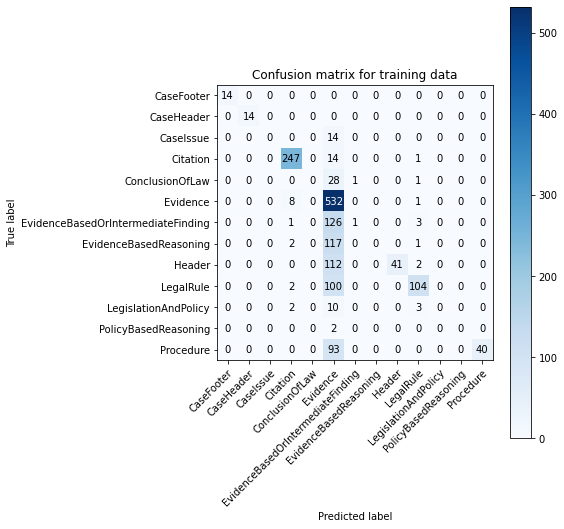

In [112]:
plot_confusion_matrix(dev_spans_labels, clf2.predict(dev_X), classes=list(clf2.classes_),
                      title='Confusion matrix for training data')
plt.show()

K-Nearest Neighbors

In [113]:
clf2 = KNeighborsClassifier(n_neighbors=13,
                    algorithm='auto',
                    metric='minkowski')
clf2 = clf2.fit(train_X, train_Y)

In [114]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf2.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf2.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.94      1.00      0.97       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.66      0.54      0.60       114
                          Citation       0.23      0.99      0.38      1967
                   ConclusionOfLaw       0.64      0.49      0.55       272
                          Evidence       0.75      0.07      0.12      3727
EvidenceBasedOrIntermediateFinding       0.70      0.10      0.18      1189
            EvidenceBasedReasoning       0.58      0.01      0.03       852
                            Header       0.96      0.96      0.96      1180
                         LegalRule       0.87      0.51      0.65      1565
              LegislationAndPolicy       0.69      0.15      0.25       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


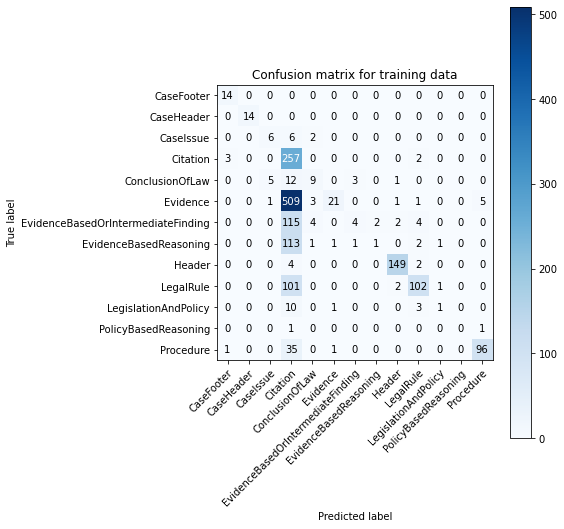

In [115]:
plot_confusion_matrix(dev_spans_labels, clf2.predict(dev_X), classes=list(clf2.classes_),
                      title='Confusion matrix for training data')
plt.show()

Multi-layer Perceptron

In [184]:
clf2 = MLPClassifier(hidden_layer_sizes=(400,),
                    activation='relu',
                    solver='adam',
                    batch_size=256,
                    alpha= 0.0001,
                    learning_rate_init=0.0001,
                    early_stopping=True,
                    max_iter=1000)
clf2 = clf2.fit(train_X, train_Y)

In [117]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf2.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf2.predict(dev_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.94      1.00      0.97       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.93      0.83      0.88       114
                          Citation       0.99      0.98      0.98      1967
                   ConclusionOfLaw       0.83      0.85      0.84       272
                          Evidence       0.87      0.94      0.91      3727
EvidenceBasedOrIntermediateFinding       0.76      0.77      0.76      1189
            EvidenceBasedReasoning       0.76      0.49      0.60       852
                            Header       0.98      0.97      0.98      1180
                         LegalRule       0.86      0.93      0.90      1565
              LegislationAndPolicy       0.72      0.34      0.46       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


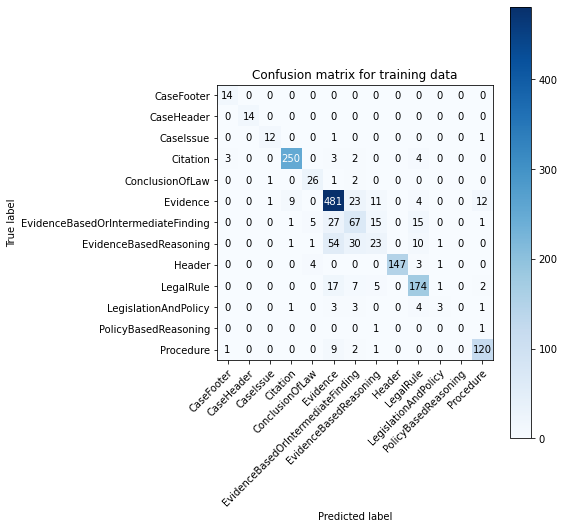

In [118]:
plot_confusion_matrix(dev_spans_labels, clf2.predict(dev_X), classes=list(clf2.classes_),
                      title='Confusion matrix for training data')
plt.show()

In [188]:
#with open(directory+'best_model_tfidf.pickle', 'wb') as handle:
#    pickle.dump(clf2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [175]:
with open(directory+'best_model_tfidf.pickle', 'rb') as handle:
     clf_tfidf = pickle.load(handle) 

### Phase 6: Error Analysis

Plot the confusion matrices for the best TFIDF and embedding-based model on the dev set

TFIDF

In [183]:
train_X, train_Y = make_feature_vectors_and_labels_tfidf(train_spans, spacy_tfidf_vectorizer)
test_X, test_Y = make_feature_vectors_and_labels_tfidf(test_spans, spacy_tfidf_vectorizer)
dev_X, dev_Y = make_feature_vectors_and_labels_tfidf(dev_spans, spacy_tfidf_vectorizer)

train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])
dev_spans_labels = np.array([s['type'] for s in dev_spans])

In [185]:
clf_tfidf = clf2

In [186]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf_tfidf.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf_tfidf.predict(dev_X)))
print('TEST:\n'+classification_report(test_spans_labels, clf_tfidf.predict(test_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metr

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.94      1.00      0.97       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.96      0.65      0.77       114
                          Citation       0.98      0.97      0.97      1967
                   ConclusionOfLaw       0.78      0.80      0.79       272
                          Evidence       0.84      0.94      0.89      3727
EvidenceBasedOrIntermediateFinding       0.73      0.71      0.72      1189
            EvidenceBasedReasoning       0.72      0.40      0.51       852
                            Header       0.97      0.97      0.97      1180
                         LegalRule       0.84      0.92      0.88      1565
              LegislationAndPolicy       0.65      0.22      0.32       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metr

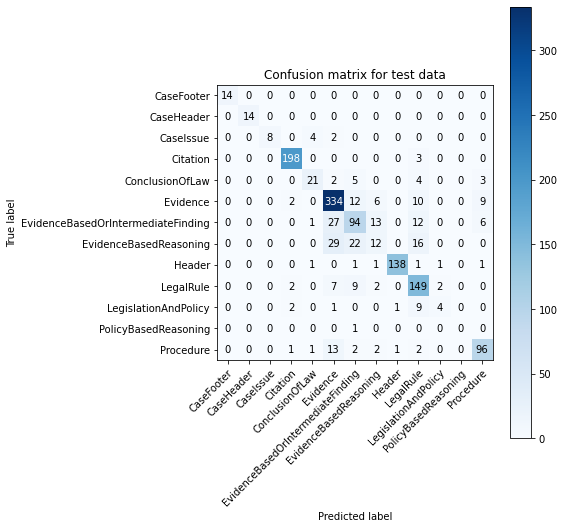

In [187]:
plot_confusion_matrix(test_spans_labels, clf_tfidf.predict(test_X), classes=list(clf_tfidf.classes_),
                      title='Confusion matrix for test data')
plt.show()

Embedding based model

In [223]:
train_X, train_Y = make_feature_vectors_and_labels_embedding(train_spans, mean, deviation)
test_X, test_Y = make_feature_vectors_and_labels_embedding(test_spans, mean, deviation)
dev_X, dev_Y = make_feature_vectors_and_labels_embedding(dev_spans, mean, deviation)

train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])
dev_spans_labels = np.array([s['type'] for s in dev_spans])

In [180]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf_embedding.predict(train_X)))
print('DEV:\n'+classification_report(dev_spans_labels, clf_embedding.predict(dev_X)))
print('TEST:\n'+classification_report(test_spans_labels, clf_embedding.predict(test_X)))

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metr

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.95      0.94      0.94       114
                          Citation       0.97      0.99      0.98      1967
                   ConclusionOfLaw       0.95      0.73      0.82       272
                          Evidence       0.86      0.90      0.88      3727
EvidenceBasedOrIntermediateFinding       0.67      0.65      0.66      1189
            EvidenceBasedReasoning       0.52      0.35      0.42       852
                            Header       0.99      0.99      0.99      1180
                         LegalRule       0.81      0.91      0.86      1565
              LegislationAndPolicy       0.67      0.27      0.38       143
              PolicyBasedReasoning       0.00      0.00      0.00        26
    

C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iremg\anaconda3\lib\site-packages\sklearn\metr

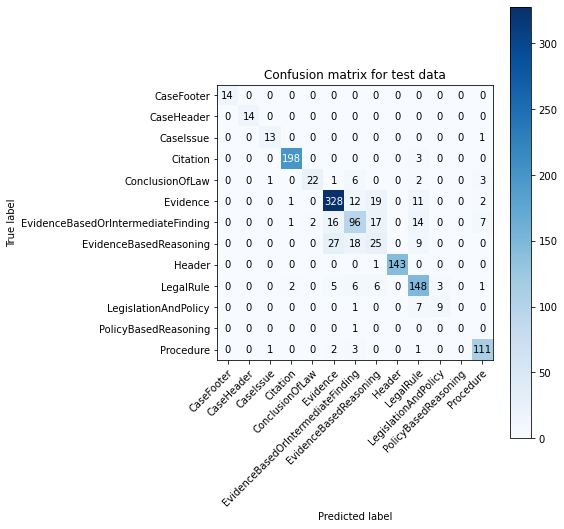

In [181]:
plot_confusion_matrix(test_spans_labels, clf_embedding.predict(test_X), classes=list(clf_embedding.classes_),
                      title='Confusion matrix for test data')
plt.show()

Overall winner, embedding based model

In [227]:
prediction_errors_embedding(clf_embedding, test_spans, test_X, test_Y,
                  select_pred_label='LegislationAndPolicy')

sentence # 63 / case 1203188.txt / @1928
pred: LegislationAndPolicy / true: LegalRule
The Veterans Claims Assistance Act of 2000 (VCAA), codified in pertinent part at 38 U.S.C.A. �� 5103, 5103A (West 2002), and the pertinent implementing regulation, codified at 38 C.F.R. � 3.159 (2011), provide that VA will assist a claimant in obtaining evidence necessary to substantiate a claim but is not required to provide assistance to a claimant if there is no reasonable possibility that such assistance would aid in substantiating the claim.

sentence # 1116 / case 0825725.txt / @2972
pred: LegislationAndPolicy / true: LegalRule
This legislation provides, among other things, for 
notice and assistance to claimants under certain 
circumstances.

sentence # 1117 / case 0825725.txt / @3092
pred: LegislationAndPolicy / true: LegalRule
VA has issued final rules to amend 
adjudication regulations to implement the provisions of VCAA.



In [228]:
prediction_errors_embedding(clf_embedding, test_spans, test_X, test_Y,
                  select_true_label='PolicyBasedReasoning')

sentence # 613 / case 1550735.txt / @1274
pred: EvidenceBasedOrIntermediateFinding / true: PolicyBasedReasoning
However, as this decision grants the benefit sought, there is no reason to belabor the impact of the VCAA on the matter, as any notice or duty to assist omission is harmless.



In [229]:
prediction_errors_embedding(clf_embedding, test_spans, test_X, test_Y,
                  select_pred_label='EvidenceBasedReasoning')

sentence # 278 / case 1507495.txt / @19735
pred: EvidenceBasedReasoning / true: EvidenceBasedOrIntermediateFinding
The November 2013 MEB rebuttal opinion, nevertheless, indicates clearly that this diagnosis is of in-service etiology, and this view is further reflected in the PEB report.

sentence # 399 / case 1203188.txt / @19365
pred: EvidenceBasedReasoning / true: EvidenceBasedOrIntermediateFinding
Here, we find that the Veteran is competent to report psychiatric manifestations and the circumstances surrounding such.

sentence # 402 / case 1203188.txt / @19792
pred: EvidenceBasedReasoning / true: EvidenceBasedOrIntermediateFinding
In this regard, we find that such are inconsistent with other (lay and medical) evidence of record. 

sentence # 406 / case 1203188.txt / @20546
pred: EvidenceBasedReasoning / true: Evidence
Equally important, when he initially sought treatment, he referenced post-service events rather than an in-service event or continuity.

sentence # 411 / case 1203188.t

In [230]:
prediction_errors_embedding(clf_embedding, test_spans, test_X, test_Y,
                  select_pred_label='EvidenceBasedOrIntermediateFinding')

sentence # 72 / case 1203188.txt / @3409
pred: EvidenceBasedOrIntermediateFinding / true: Evidence
Thus, VA's duty to notify in this case has been satisfied. 

sentence # 93 / case 0825725.txt / @2294
pred: EvidenceBasedOrIntermediateFinding / true: ConclusionOfLaw
A chronic low back disability was not incurred in or 
aggravated by the veteran's active duty service, nor may a 
chronic low back disability be presumed to have been incurred 
in such service, nor is a chronic low back disability 
proximately due to or the result of the veteran's service 
connected left shoulder and clavicle disabilities.

sentence # 189 / case 1048193.txt / @7132
pred: EvidenceBasedOrIntermediateFinding / true: EvidenceBasedReasoning
 As 
a preponderance of the evidence supports the award of service 
connection, the benefit-of-the-doubt doctrine is applicable in 
the instant appeal.

sentence # 205 / case 0730252.txt / @999
pred: EvidenceBasedOrIntermediateFinding / true: ConclusionOfLaw
A chronic headache

In [231]:
prediction_errors_embedding(clf_embedding, test_spans, test_X, test_Y,
                  select_pred_label='LegalRule')

sentence # 67 / case 1203188.txt / @2645
pred: LegalRule / true: LegislationAndPolicy
The Board also notes that the United States Court of Appeals for Veterans Claims (Court) has held that the plain language of 38 U.S.C.A. � 5103(a) (West 2002), requires that notice to a claimant pursuant to the VCAA be provided "at the time" that, or "immediately after," VA receives a complete or substantially complete application for VA-administered benefits. 

sentence # 69 / case 1203188.txt / @3063
pred: LegalRule / true: LegislationAndPolicy
The timing requirement enunciated in Pelegrini applies equally to the initial disability-rating and effective-date elements of a service connection claim.

sentence # 164 / case 1048193.txt / @3078
pred: LegalRule / true: Citation
38 C.F.R. � 3.385.  Use of 38 C.F.R. � 3.385 to 
define a disability under 38 U.S.C.A. � 1110 as it pertains to 
hearing loss has been recognized by the Court as a reasonable 
interpretation of the statute. 

sentence # 186 / case 1

In [232]:
prediction_errors_embedding(clf_embedding, test_spans, test_X, test_Y,
                  select_pred_label='Evidence')

sentence # 61 / case 1507495.txt / @20256
pred: Evidence / true: ConclusionOfLaw
Service connection for gouty arthritis, encompassing multiple joint pains, is granted.

sentence # 212 / case 0730252.txt / @1516
pred: Evidence / true: LegalRule
 This 
change in the law is applicable to all claims filed on or 
after the date of enactment of the VCAA, or filed before the 
date of enactment and not yet final as of that date.

sentence # 281 / case 1507495.txt / @18578
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Reports of a series of VA examinations conducted in September 2014 indicate that the Veteran had gouty arthritis affecting all joints bilaterally (i.e., shoulders, elbows, wrists, hands/fingers, hips, knees, ankles, feet/toes).  

sentence # 380 / case 1203188.txt / @15885
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Although post service treatment records show an assessment of PTSD and possible PTSD, there is no evidence diagnosing PTSD in accordance with

In [233]:
prediction_errors_embedding(clf_embedding, test_spans, test_X, test_Y,
                  select_pred_label='ConclusionOfLaw')

sentence # 466 / case 1522066.txt / @1865
pred: ConclusionOfLaw / true: EvidenceBasedOrIntermediateFinding
Service connection will therefore be granted.

sentence # 981 / case 1222885.txt / @8689
pred: ConclusionOfLaw / true: EvidenceBasedOrIntermediateFinding
Resolving reasonable doubt in favor of the Veteran, service connection for PTSD is granted.



In [234]:
prediction_errors_embedding(clf_embedding, test_spans, test_X, test_Y,
                  select_pred_label='Procedure')

sentence # 44 / case 1507495.txt / @1700
pred: Procedure / true: EvidenceBasedOrIntermediateFinding
There is competent evidence showing a disorder encompassing multiple joint pains, diagnosed as gouty arthritis, that was caused by service.

sentence # 46 / case 1507495.txt / @1868
pred: Procedure / true: ConclusionOfLaw
Gouty arthritis, encompassing multiple joint pains, was incurred in service.  

sentence # 276 / case 1507495.txt / @2564
pred: Procedure / true: LegalRule
Indeed, any such action would result only in delay.

sentence # 292 / case 1203188.txt / @3780
pred: Procedure / true: EvidenceBasedOrIntermediateFinding
The Board acknowledges that the Veteran has not been afforded a VA examination in relation to his claim for service connection.

sentence # 835 / case 1108882.txt / @1048
pred: Procedure / true: EvidenceBasedOrIntermediateFinding
1.  In December 2007, the RO denied the Veteran's claim for service connection for arthritis.

sentence # 836 / case 1108882.txt / @1143
p

### Phase 8: Code Deliverable

In [ ]:
import luima_sbd.sbd_utils

In [ ]:
path_to_text_file = 'unlabeled/0600090.txt'
with open(directory+path_to_text_file, mode='r', encoding='latin-1') as f:
    plainText = f.read()

In [ ]:
# generating a list of annotations from the BVA decision with luima_sbd
unlabeled = [] 
regex = re.compile(r'[\t\r\n]')

plainText.encode('latin-1','ignore') 
plainText=regex.sub(" ", plainText)
plainText = plainText.replace("\\s+", " ") # multiple spaces

annotations = luima_sbd.sbd_utils.text2sentences(plainText) 
annotation_offset = luima_sbd.sbd_utils.text2sentences(plainText, offsets=True)
annotations_start=[e[0] for e in annotation_offset]
annotations_end=[e[1] for e in annotation_offset]

for i in range(len(annotations)):
    annotation={
        'document':id,
        'start':annotations_start[i],
        'start_normalized': annotations_start[i] / len(plainText),
        'end':annotations_end[i],
        'end_normalized': annotations_end[i] / len(plainText),
        'txt':annotations[i]
    }
    unlabeled.append(annotation)


In [ ]:
len(unlabeled)

In [ ]:
unlabeled[0]

In [ ]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case(u'Pub L. No.', [{ORTH: u'Pub L. No.'}])
nlp.tokenizer.add_special_case(u'Veterans Affairs (VA)', [{ORTH: u'Veterans Affairs (VA)'}])
nlp.tokenizer.add_special_case(u'Regional Office (RO)', [{ORTH: u'Regional Office (RO)'}])
nlp.tokenizer.add_special_case(u'Fed. Reg.', [{ORTH: u'Fed. Reg.'}])
nlp.tokenizer.add_special_case(u'Fed. Cir.', [{ORTH: u'Fed. Cir.'}])

In [ ]:
def spacy_tokenize3(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            t_ = t.lemma_.encode('ascii', 'ignore').decode('utf-8', 'ignore')
            t_ = t_.lower()
            t_ = re.sub(r'[^a-zA-Z0-9]', '', t_)
            if t_ not in stop_words:
                clean_tokens.append(t_)
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize3(s['txt'])

In [ ]:
spans_add_spacy_tokens(unlabeled)

In [ ]:
unlabeled[0]

In [ ]:
def average_embedding_vector(spans):
    avg_lst = []
    for i in range(len(spans)): #for each sentence
        vec_sum = 0
        for j in range(len(spans[i]['tokens_spacy'])): #for each token
            vec_sum = vec_sum + model.get_word_vector(spans[i]['tokens_spacy'][j])
            #vec_sum = vec_sum + np.sum(model.get_word_vector(spans[i]['tokens_spacy'][j]))
        vec_avg = vec_sum/len(spans[i]['tokens_spacy'])
        avg_lst.append(vec_avg)
    return avg_lst

In [ ]:
def normalized_vector(spans):
    length_list = [len(i['tokens_spacy']) for i in spans]
    total_sum = np.sum(length_list)
    mean = total_sum / len(length_list)
    
    deviation = 0
    for i in range(len(length_list)):
        deviation = (deviation + (length_list[i] - mean)) ** 2
    
    deviation = deviation / len(length_list)
    deviation = math.sqrt(deviation)
    
    for i in range(len(length_list)):
        length_list[i] = (length_list[i] - mean)/deviation
    
    return length_list

In [ ]:
def make_feature_vectors(spans):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    average_vector = np.array(average_embedding_vector(spans))
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    normalized_lst = normalized_vector(spans)
    X = np.concatenate((average_vector,
                        np.expand_dims(starts_normalized, axis=1),
                        np.expand_dims(normalized_lst, axis=1)), axis=1)
    return X

In [ ]:
# loading the best model
with open(directory+'best_model.pickle', 'rb') as handle:
     clf = pickle.load(handle)   

In [ ]:
# predicting the annotations
unlabeled_X = make_feature_vectors(unlabeled)
unlabeled_X = np.nan_to_num(unlabeled_X)

pred = clf.predict(unlabeled_X)

In [ ]:
len(pred)

In [ ]:
unlabeled[0]['txt']

In [ ]:
pred[0]

In [ ]:
# pretty printing sentence: type
for i in range(len(unlabeled)):
    sent = unlabeled[i]['txt']
    typ = pred[i]
    print(sent+ ': '+typ)